# Курсовой проект

**Задача**

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**

Credit Default - факт невыполнения кредитных обязательств

**Метрика качества**

F1-score (sklearn.metrics.f1_score)

**Требования к решению**

*Целевая метрика*
* F1 > 0.5
* Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

*Решение должно содержать*
1. Тетрадка Jupyter Notebook с кодом Вашего решения
2. Укажите свой ник на kaggle

*Рекомендации для файла с кодом (ipynb)*
1. Файл должен содержать заголовки и комментарии (markdown)
2. Повторяющиеся операции лучше оформлять в виде функций
3. Не делать вывод большого количества строк таблиц (5-10 достаточно)
4. По возможности добавлять графики, описывающие данные (около 3-5)
5. Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта
6. Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний)
7. Весь проект должен быть в одном скрипте (файл ipynb).
8. Допускается применение библиотек Python и моделей машинного обучения,
которые были в данном курсе.

**Сроки сдачи**

Cдать проект нужно в течение 7 дней после окончания последнего вебинара.

**Построение модели классификации**
1. Обзор обучающего датасета
2. Обработка выбросов
3. Обработка пропусков
4. Анализ данных
5. Отбор признаков
6. Балансировка классов
7. Подбор моделей, получение бейзлана
8. Выбор наилучшей модели, настройка гиперпараметров
9. Проверка качества, борьба с переобучением
10. Интерпретация результатов

**Прогнозирование на тестовом датасете**
1. Выполнить для тестового датасета те же этапы обработки и построения признаков
2. Спрогнозировать целевую переменную, используя модель, построенную на обучающем датасете
3. Прогнозы должны быть для всех примеров из тестового датасета (для всех строк)
4. Соблюдать исходный порядок примеров из тестового датасета

**Описание датасета**

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - баллы кредитного рейтинга
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [183]:
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [184]:
import numpy as np
import pandas as pd


from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, plot_confusion_matrix, plot_precision_recall_curve, precision_recall_curve, recall_score, plot_roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve, KFold, GridSearchCV, RandomizedSearchCV 
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import lightgbm as lgbm, catboost as catb
from xgboost import XGBClassifier
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

import pickle
import random

%matplotlib inline

In [185]:
# отчет по метрикам
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [186]:
# функция для балансировки классов
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [187]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [188]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [189]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [190]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'

In [191]:
df = pd.read_csv(TRAIN_DATASET_PATH)

In [192]:
df_test = pd.read_csv(TEST_DATASET_PATH)

# Exploratory data analysis

In [193]:
df.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0       Own Home       482087.0                  NaN        0.0   
1       Own Home      1025487.0            10+ years        0.0   
2  Home Mortgage       751412.0              8 years        0.0   
3       Own Home       805068.0              6 years        0.0   
4           Rent       776264.0              8 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                     11.0                     26.3             685960.0   
1                     15.0                     15.3            1181730.0   
2                     11.0                     35.0            1182434.0   
3                      8.0                     22.5             147400.0   
4                     13.0                     13.6             385836.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        1.0                           NaN           1.0   
1                        0.0                           NaN           0.0   
2                        0.0                           NaN           0.0   
3                        1.0                           NaN           1.0   
4                        1.0                           NaN           0.0   

              Purpose        Term  Current Loan Amount  \
0  debt consolidation  Short Term           99999999.0   
1  debt consolidation   Long Term             264968.0   
2  debt consolidation  Short Term           99999999.0   
3  debt consolidation  Short Term             121396.0   
4  debt consolidation  Short Term             125840.0   

   Current Credit Balance  Monthly Debt  Credit Score  Credit Default  
0                 47386.0        7914.0         749.0               0  
1                394972.0       18373.0         737.0               1  
2                308389.0       13651.0         742.0               0  
3                 95855.0       11338.0         694.0               0  
4                 93309.0        7180.0         719.0               0

In [194]:
df.shape

(7500, 17)

In [195]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [196]:
df.describe()

Annual Income    Tax Liens  Number of Open Accounts  \
count   5.943000e+03  7500.000000              7500.000000   
mean    1.366392e+06     0.030133                11.130933   
std     8.453392e+05     0.271604                 4.908924   
min     1.645970e+05     0.000000                 2.000000   
25%     8.443410e+05     0.000000                 8.000000   
50%     1.168386e+06     0.000000                10.000000   
75%     1.640137e+06     0.000000                14.000000   
max     1.014934e+07     7.000000                43.000000   

       Years of Credit History  Maximum Open Credit  \
count              7500.000000         7.500000e+03   
mean                 18.317467         9.451537e+05   
std                   7.041946         1.602622e+07   
min                   4.000000         0.000000e+00   
25%                  13.500000         2.792295e+05   
50%                  17.000000         4.781590e+05   
75%                  21.800000         7.935015e+05   
max                  57.700000         1.304726e+09   

       Number of Credit Problems  Months since last delinquent  Bankruptcies  \
count                7500.000000                   3419.000000   7486.000000   
mean                    0.170000                     34.692600      0.117152   
std                     0.498598                     21.688806      0.347192   
min                     0.000000                      0.000000      0.000000   
25%                     0.000000                     16.000000      0.000000   
50%                     0.000000                     32.000000      0.000000   
75%                     0.000000                     50.000000      0.000000   
max                     7.000000                    118.000000      4.000000   

       Current Loan Amount  Current Credit Balance   Monthly Debt  \
count         7.500000e+03            7.500000e+03    7500.000000   
mean          1.187318e+07            2.898332e+05   18314.454133   
std           3.192612e+07            3.178714e+05   11926.764673   
min           1.124200e+04            0.000000e+00       0.000000   
25%           1.801690e+05            1.142565e+05   10067.500000   
50%           3.095730e+05            2.093230e+05   16076.500000   
75%           5.198820e+05            3.604062e+05   23818.000000   
max           1.000000e+08            6.506797e+06  136679.000000   

       Credit Score  Credit Default  
count   5943.000000     7500.000000  
mean    1151.087498        0.281733  
std     1604.451418        0.449874  
min      585.000000        0.000000  
25%      711.000000        0.000000  
50%      731.000000        0.000000  
75%      743.000000        1.000000  
max     7510.000000        1.000000

In [197]:
dupl = df[df.duplicated()].shape[0]# Проверим наличие дубликатов
dupl

0

In [198]:
TARGET_NAME = 'Credit Default'
FEATURE_NAMES = df.columns.drop([TARGET_NAME])

In [199]:
FEATURE_NAMES

Index(['Home Ownership', 'Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Purpose', 'Term',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score'],
      dtype='object')

In [200]:
NUM_FEATURE_NAMES = ['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies',
       'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
       'Credit Score']

CAT_FEATURE_NAMES = ['Home Ownership', 'Purpose', 'Term']
FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

In [201]:
for colname in CAT_FEATURE_NAMES:
    df[colname] = pd.Categorical(df[colname])
    
df[CAT_FEATURE_NAMES].dtypes

Home Ownership    category
Purpose           category
Term              category
dtype: object

In [202]:
X = df[FEATURE_NAMES]
y = df[TARGET_NAME]

Дальнейший анализ, нормализацию и расчет показателей будем проводить на тренировочной выборке, чтобы потом применить эти расчеты к тестовой

In [203]:
x_train, x_valid, y_train, y_valid =train_test_split(X, y, test_size = 0.25, random_state = 100)

Посмотрим баланс классов в тренировочной и тестовой выборке

In [204]:
y_train.value_counts()

0    4057
1    1568
Name: Credit Default, dtype: int64

In [205]:
y_valid.value_counts()

0    1330
1     545
Name: Credit Default, dtype: int64

### Обработка пропусков, некорректных данных и анализ выбросов

In [206]:
x_train['Months since last delinquent'].unique() #смотрим уникальные значения столбца с количеством месяцев просрочки платежа 

array([ 70.,  14.,   1.,  nan,  15.,  43.,  61.,   9.,  25.,  11.,  31.,
        17.,  21.,  49.,  32.,  57.,  81.,  47.,  60.,  74.,   7.,  30.,
        41.,  59.,  20.,  54.,  16.,  24.,  53.,  23.,   4.,  19.,  28.,
        48.,  67.,  35.,  52.,  77.,  22.,  42.,  64.,  68.,  45.,  40.,
        44.,  39.,   0.,  46.,   5.,  10.,  12.,  62.,  73.,  76.,   2.,
        18.,  63.,  33.,  34.,  65.,  13.,  26.,  37.,   6.,  51.,  83.,
        55.,  36.,  38.,  58.,   8.,  27.,  72.,   3.,  79.,  56.,  80.,
        29., 118.,  78.,  71.,  66.,  50.,  69.,  75.,  82.,  84.,  91.,
        92.])

Напишем функцию перевода категориального признака Years in current job в числовой, так как для нашей задачи предпочтительнее учитывать этот признак как числовой

In [207]:
def cat_int(df):
    for i in range(11):
        df.loc[df['Years in current job'] == str(i)+' years', 'Years in current job'] = i
        df.loc[df['Years in current job'] == str(i)+' year', 'Years in current job'] = i
        df.loc[df['Years in current job'] == str(i)+'+ years', 'Years in current job'] = i
        df.loc[df['Years in current job'] == '< ' + str(i)+' year', 'Years in current job'] = i-0.5
    df.loc[df['Home Ownership'] == 'Have Mortgage', 'Home Ownership'] = 'Home Mortgage' # заменим аналоги на одну категорию
        
    return df

In [208]:
x_train = cat_int(x_train)

In [209]:
x_train['Years in current job'].unique()

array([1, 10, 7, 2, 3, 9, 6, 0.5, 5, 8, nan, 4], dtype=object)

Рассчитаем медианные значения признаков

In [210]:
med_annual_income = x_train['Annual Income'].median()

In [211]:
med_years_in_curr_job = x_train['Years in current job'].median()

In [212]:
med_curr_loan_amount = x_train['Current Loan Amount'].median()

In [213]:
med_credit_score = x_train['Credit Score'].median()

Напишем функцию заполнения пропусков

In [214]:
def fill_nan(df):
    df['Bankruptcies'].fillna(0, inplace = True) # заполняем 0 значением, так как этот признак нецелесообразно заполнять медианой и вероятность отсутствия банкротств у тех объектов, в которых этот признак не определен, больше
    df['Months since last delinquent'].fillna(0, inplace = True)# заполняем 0 значением, так как скорее всего если этот признак не указан, то месяцев просрочки не было
    df['Annual Income'].fillna(med_annual_income, inplace = True)# заполняем медианой годовой доход при его отсутствии
    df['Years in current job'].fillna(med_years_in_curr_job, inplace = True)# заполняем медианой количество лет на текущей работе
    df['Credit Score'].fillna(med_credit_score, inplace = True) # заполняем медианой кредитный скор 
    return df

In [215]:
x_train = fill_nan(x_train)

In [216]:
x_train.info() #Убедимся, что на данный момент пропусков нет

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 1172 to 5640
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Annual Income                 5625 non-null   float64 
 1   Years in current job          5625 non-null   float64 
 2   Tax Liens                     5625 non-null   float64 
 3   Number of Open Accounts       5625 non-null   float64 
 4   Years of Credit History       5625 non-null   float64 
 5   Maximum Open Credit           5625 non-null   float64 
 6   Number of Credit Problems     5625 non-null   float64 
 7   Months since last delinquent  5625 non-null   float64 
 8   Bankruptcies                  5625 non-null   float64 
 9   Current Loan Amount           5625 non-null   float64 
 10  Current Credit Balance        5625 non-null   float64 
 11  Monthly Debt                  5625 non-null   float64 
 12  Credit Score                  5625 non-null  

### Посмотрим распределение категориальных признаков.

Text(0.5, 1.0, 'Home Ownership')

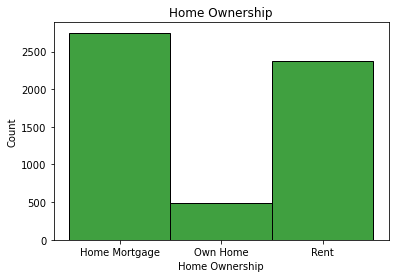

In [217]:
sns.histplot(x_train['Home Ownership'], binwidth = 100, color = 'green')
plt.title('Home Ownership')

In [218]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,7

Text(0.5, 1.0, 'Purpose')

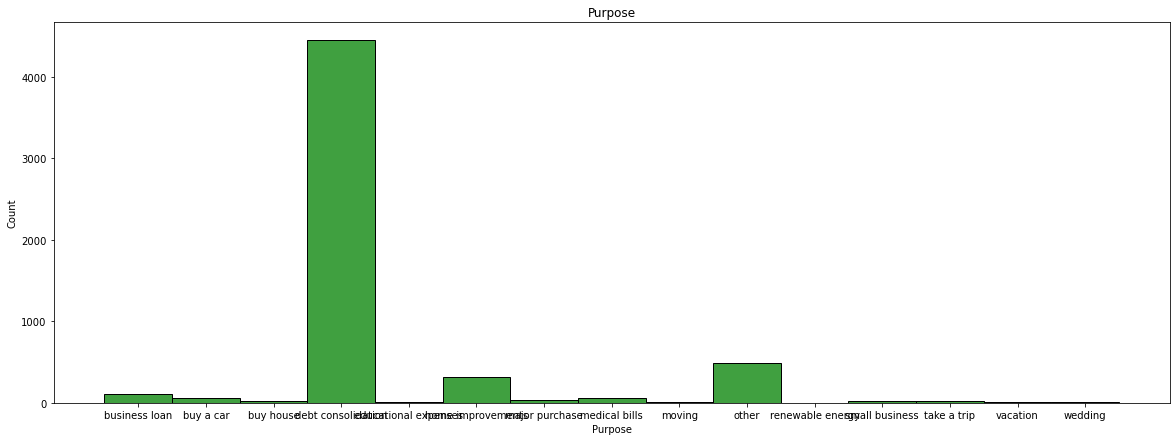

In [219]:
sns.histplot(x_train['Purpose'], color = 'green')
plt.title('Purpose')

Исходя из анализа гистограммы следует, что большая часть долговых обязательств по цели получения связана с консолидацией долгов, что в свою очередь повышает риск невозврата кредита.

Text(0.5, 1.0, 'Term')

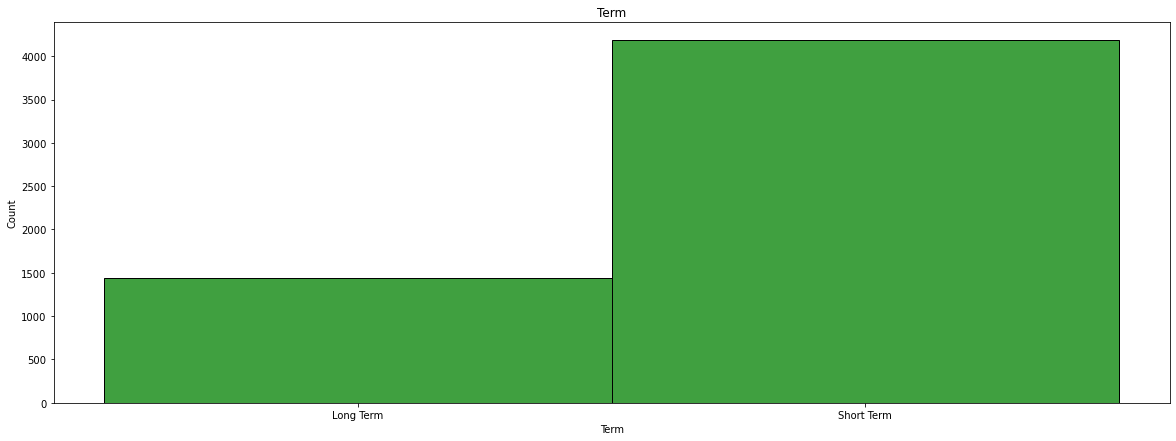

In [220]:
sns.histplot(x_train['Term'], binwidth = 100, color = 'green')
plt.title('Term')

В нашем датасете преобладают краткосрочные займы

### Проанализируем выбросы и аномалии (если они имеются) в числовых признаках, а также посмотрим тепловую карту корреляции признаков

Посмотрим распределение признака годовой доход и оценим наличие выбросов

Text(0.5, 1.0, 'Годовой доход')

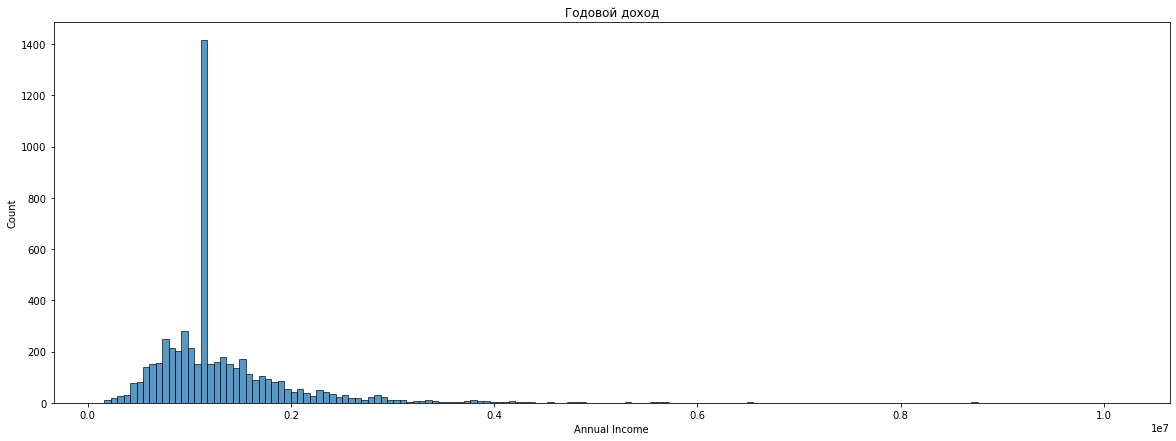

In [221]:
sns.histplot(x_train['Annual Income'])
plt.title('Годовой доход')

Большое количество данных одного значения в гистограмме связано с заполнением пропущенных значений годового дохода медианой

In [222]:
px.box(x_train, y = 'Annual Income') # посмотрим ящик с усами для анализа выбросов

Видим, что распределение годового дохода имеет "хвост" в сторону большего дохода. Но выбросами или аномалиями эти данные назвать нельзя, это связано с наличием меньшего процента заемщиков с высоким годовым доходом. Оставляем эти данные как есть.

Проанализируем признак количество лет на текущей работе

Text(0.5, 1.0, 'Количество лет на текущей работе')

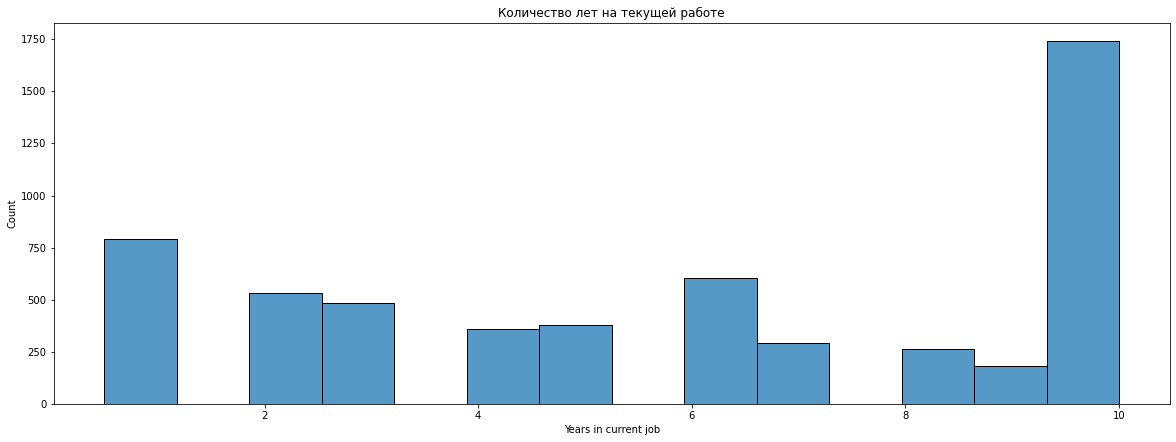

In [223]:
sns.histplot(x_train['Years in current job'])
plt.title('Количество лет на текущей работе')

In [224]:
x_train['Years in current job'].value_counts()

10.0    1740
6.0      603
2.0      533
3.0      485
0.5      417
5.0      378
1.0      374
4.0      359
7.0      291
8.0      262
9.0      183
Name: Years in current job, dtype: int64

Больше всего клиентов с длительным периодом работы на текущем месте

Text(0.5, 1.0, 'Налоговые обременения')

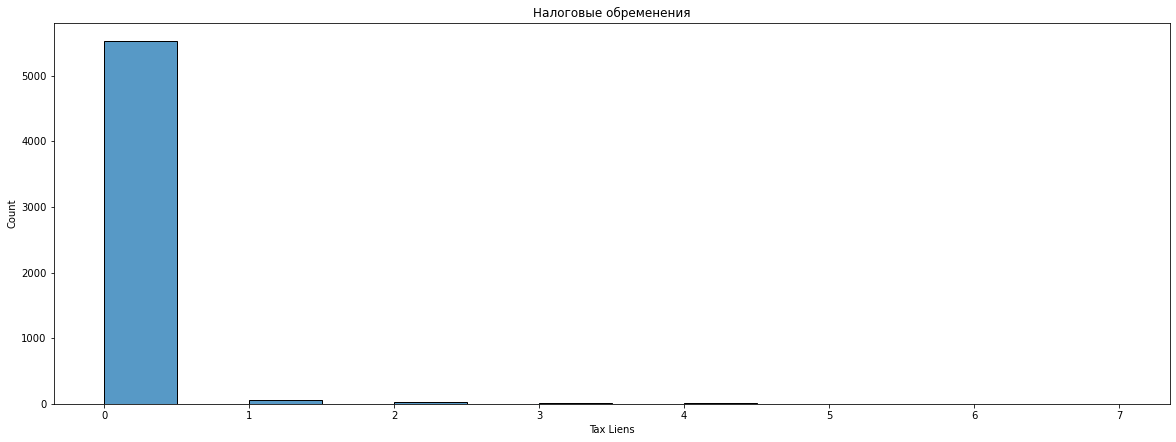

In [225]:
sns.histplot(x_train['Tax Liens'])
plt.title('Налоговые обременения')

По налоговым обременениям аномалий не выявлено. Большая часть клиентов обременений не имеет

Text(0.5, 1.0, 'Количество открытых счетов')

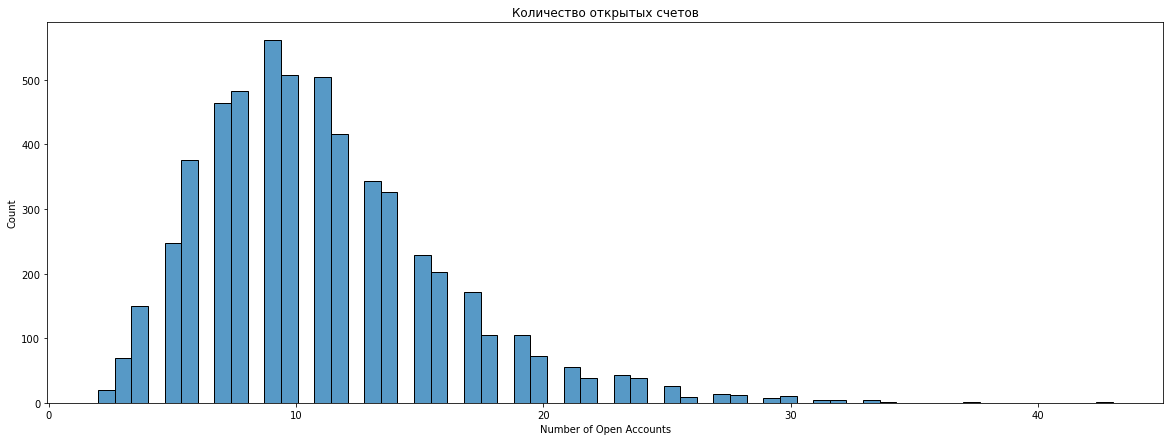

In [226]:
sns.histplot(x_train['Number of Open Accounts'])
plt.title('Количество открытых счетов')

In [227]:
px.box(x_train, y = 'Number of Open Accounts') # посмотрим ящик с усами для анализа выбросов

Распределение неравномерное, имеет хвост в сторону большого количества счетов, но выбросами их не считаем

Text(0.5, 1.0, 'Количество лет кредитной истории')

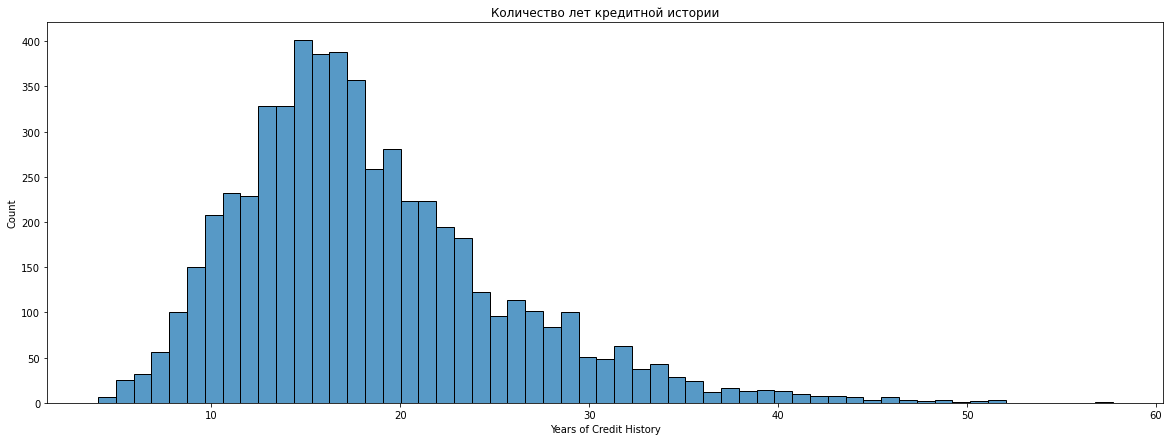

In [228]:
sns.histplot(x_train['Years of Credit History'])
plt.title('Количество лет кредитной истории')

In [229]:
px.box(x_train, y = 'Years of Credit History') # посмотрим ящик с усами для анализа выбросов

Распределение близко к нормальному с небольшим "хвостом" в сторону большого количества лет кредитной истории, но данные не аномальные, оставляем их без изменений

In [230]:
px.box(x_train, y = 'Maximum Open Credit') # посмотрим ящик с усами для анализа выбросов

<AxesSubplot:xlabel='Maximum Open Credit', ylabel='Credit Default'>

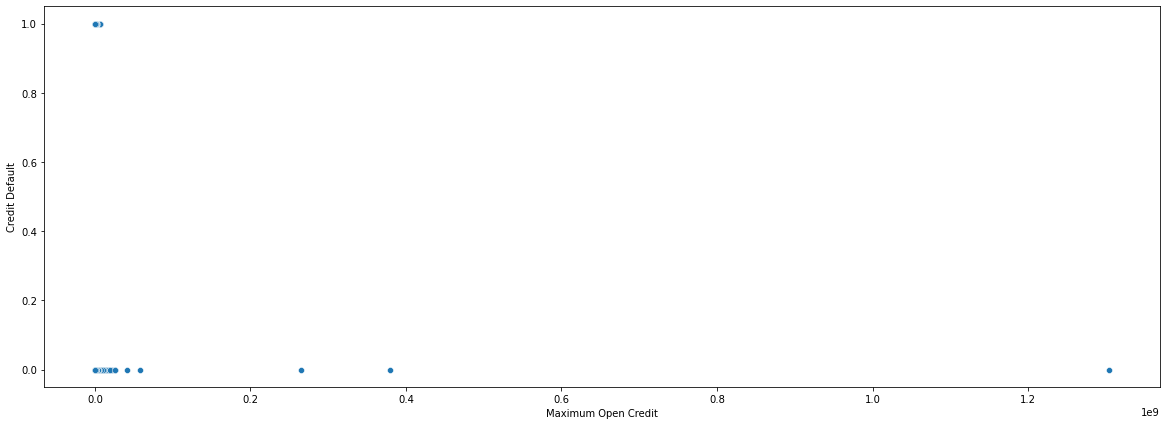

In [231]:
#Посмотрим зависимость credit default от Maximum Open Credit
sns.scatterplot(data = df, x = 'Maximum Open Credit', y = 'Credit Default')

Рассмотрим данные, значение которых превосходит 200 млн

In [232]:
x_train[x_train['Maximum Open Credit']>200000000]

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
617       1168519.0                   3.0        0.0                     13.0   
44        1334256.0                  10.0        0.0                     17.0   
2617      3217802.0                  10.0        0.0                     12.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
617                      27.5         1.304726e+09                        0.0   
44                       15.4         3.800523e+08                        1.0   
2617                     35.5         2.655129e+08                        0.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  \
617                            0.0           0.0             529892.0   
44                            35.0           0.0              33110.0   
2617                           0.0           0.0              50116.0   

      Current Credit Balance  Monthly Debt  Credit Score Home Ownership  \
617                1126814.0        5492.0         732.0  Home Mortgage   
44                  656450.0       34357.0         729.0  Home Mortgage   
2617               1834450.0       20272.0         750.0  Home Mortgage   

                 Purpose        Term  
617   debt consolidation  Short Term  
44           take a trip  Short Term  
2617               other  Short Term

Таких данных всего 3 объекта, их можно удалить, так как при работе модели такие выбросы могут искажать результаты

In [233]:
x_train.drop(labels = [44, 617, 2617], axis = 0, inplace = True)
y_train.drop(labels = [44, 617, 2617], axis = 0, inplace = True)

Text(0.5, 1.0, 'Наибольший открытый кредит')

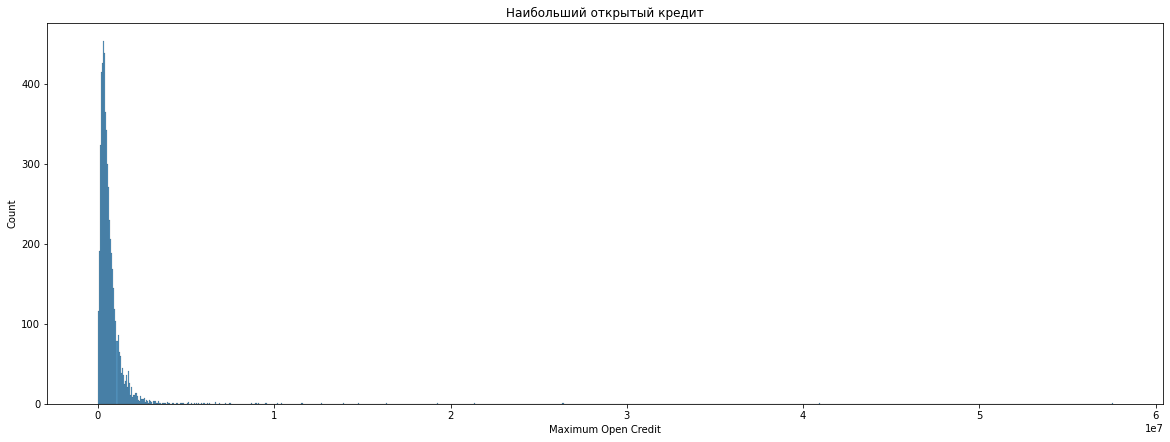

In [234]:
sns.histplot(x_train['Maximum Open Credit'])
plt.title('Наибольший открытый кредит')

Text(0.5, 1.0, 'Количество проблем с кредитом')

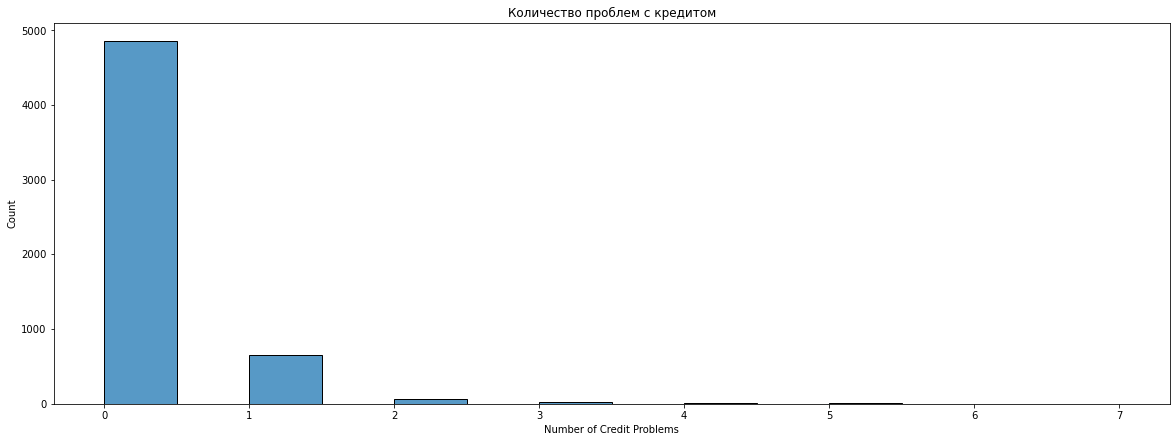

In [235]:

sns.histplot(x_train['Number of Credit Problems'])
plt.title('Количество проблем с кредитом')

В данных по количеству проблем с кредитом аномалий не выявлено

Text(0.5, 1.0, 'Количество месяцев с последней просрочки платежа')

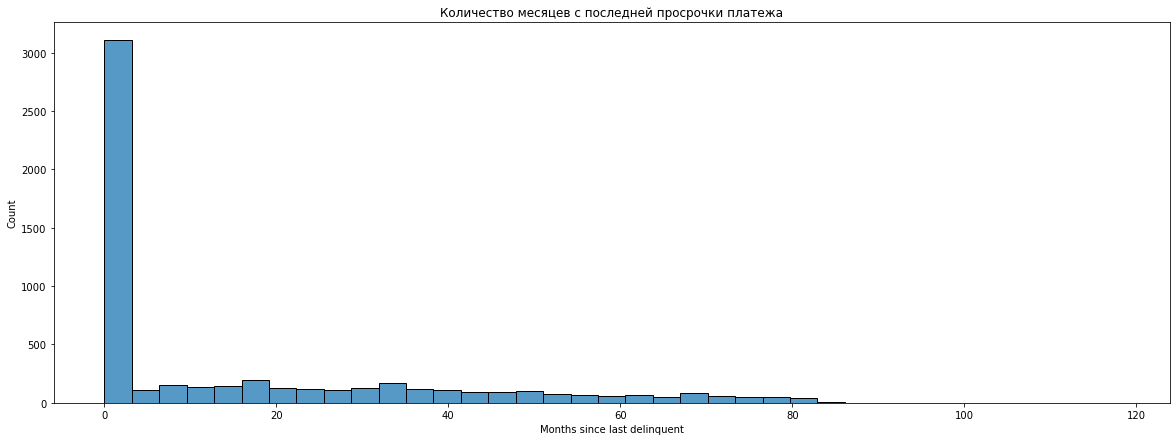

In [236]:
sns.histplot(x_train['Months since last delinquent'])
plt.title('Количество месяцев с последней просрочки платежа')

Ожидаемо для большинства объектов этот показатель равен 0. Аномалий не выявлено.

Text(0.5, 1.0, 'Банкротства')

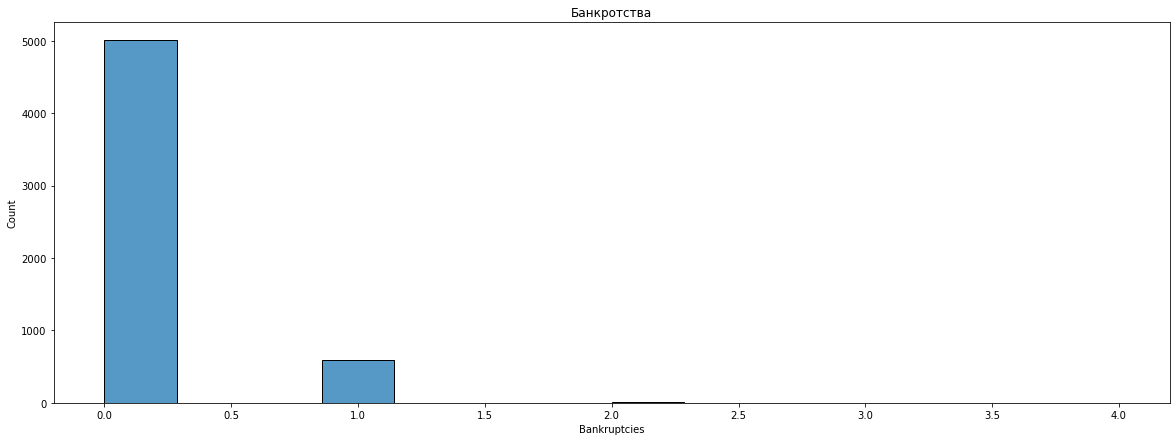

In [237]:
sns.histplot(x_train['Bankruptcies'])
plt.title('Банкротства')

Данные по банкротству также без аномалий

In [238]:
px.box(x_train, y = 'Current Loan Amount') # посмотрим ящик с усами для анализа выбросов

<AxesSubplot:xlabel='Current Loan Amount', ylabel='Credit Default'>

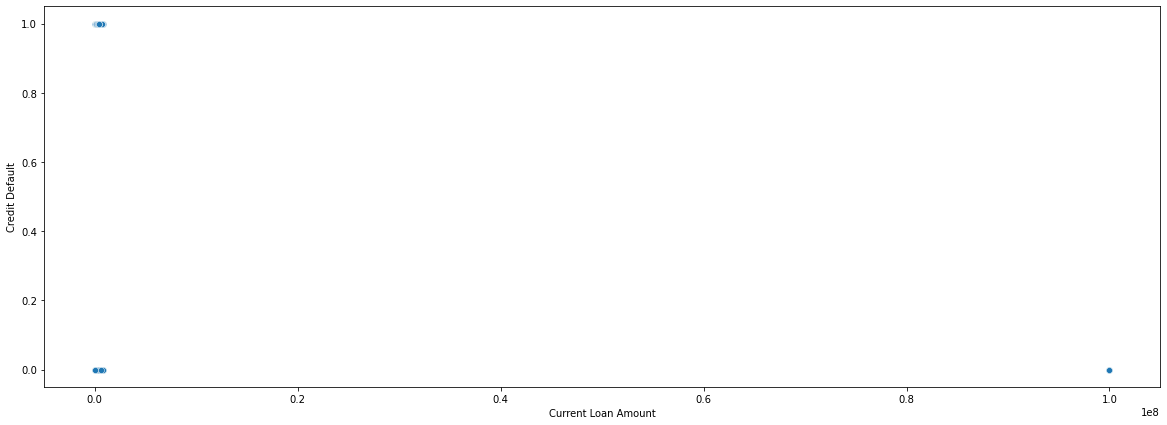

In [239]:
#Посмотрим зависимость credit default от Current Loan Amount
sns.scatterplot(data = df, x = 'Current Loan Amount', y = 'Credit Default')

Среди крайне крупных сумм Current Loan Amount нет объектов с Credit Default равным 1.

Есть вероятность, эти крупные суммы являются аномалиями, проанализируем очень крупные суммы

In [240]:
x_train[x_train['Current Loan Amount']>1000000]

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
7285      1028242.0                   7.0        0.0                      6.0   
5333      1267395.0                   3.0        0.0                     11.0   
2577      1935283.0                  10.0        0.0                     30.0   
5243       980685.0                   9.0        0.0                      8.0   
1007      1247236.0                   5.0        0.0                      6.0   
...             ...                   ...        ...                      ...   
2          751412.0                   8.0        0.0                     11.0   
2651      1303552.0                   3.0        0.0                      5.0   
1899      1258959.0                   0.5        0.0                     10.0   
5646      2135182.0                   6.0        0.0                     28.0   
4149      1222156.0                   8.0        0.0                     17.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
7285                     13.9             123596.0                        0.0   
5333                     11.8             137676.0                        1.0   
2577                     15.5            1241130.0                        0.0   
5243                     12.0             168080.0                        1.0   
1007                     14.2              59972.0                        0.0   
...                       ...                  ...                        ...   
2                        35.0            1182434.0                        0.0   
2651                     11.9             562980.0                        0.0   
1899                     11.2             396616.0                        0.0   
5646                     22.1            3015760.0                        0.0   
4149                     12.5             814946.0                        0.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  \
7285                          43.0           0.0           99999999.0   
5333                          61.0           0.0           99999999.0   
2577                           9.0           0.0           99999999.0   
5243                           0.0           1.0           99999999.0   
1007                          25.0           0.0           99999999.0   
...                            ...           ...                  ...   
2                              0.0           0.0           99999999.0   
2651                           0.0           0.0           99999999.0   
1899                          32.0           0.0           99999999.0   
5646                          12.0           0.0           99999999.0   
4149                           0.0           0.0           99999999.0   

      Current Credit Balance  Monthly Debt  Credit Score Home Ownership  \
7285                 56791.0        9254.0         734.0  Home Mortgage   
5333                 34124.0       25559.0         719.0  Home Mortgage   
2577                286197.0       30803.0         747.0  Home Mortgage   
5243                119472.0       13566.0         721.0  Home Mortgage   
1007                 26467.0        6101.0         737.0           Rent   
...                      ...           ...           ...            ...   
2                   308389.0       13651.0         742.0  Home Mortgage   
2651                296096.0       14013.0         748.0           Rent   
1899                153102.0       17416.0         728.0           Rent   
5646                768322.0       43593.0         742.0  Home Mortgage   
4149                289978.0       23628.0         745.0  Home Mortgage   

                 Purpose        Term  
7285  debt consolidation  Short Term  
5333   home improvements  Short Term  
2577  debt consolidation  Short Term  
5243  debt consolidation  Short Term  
1007       business loan  Short Term  
...                  ...         ...  
2     deb

Текущая сумма кредита в этих данных аномально высокая. Таких данных много, принимаем решения заменить текущую сумму кредита медианой

In [241]:
x_train.loc[x_train['Current Loan Amount']>1000000, 'Current Loan Amount'] = med_curr_loan_amount

Text(0.5, 1.0, 'текущая сумма кредита')

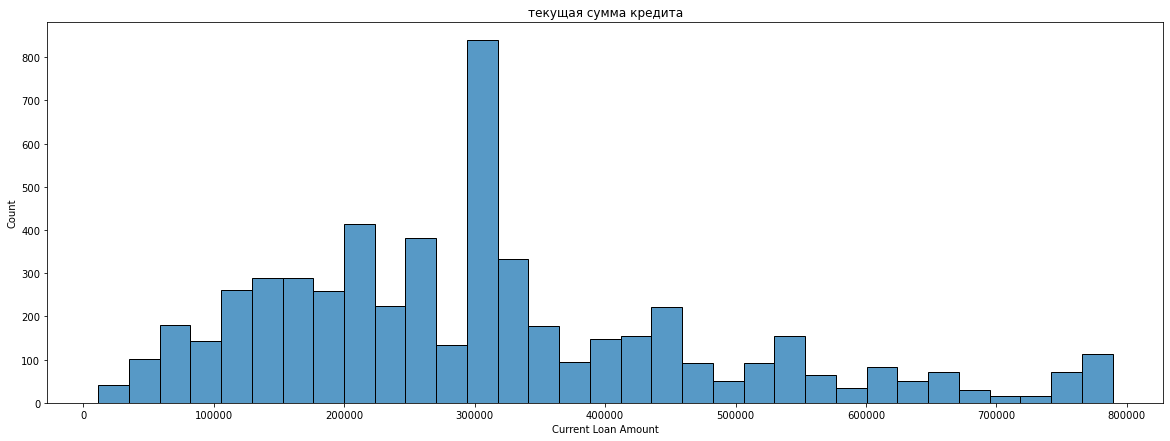

In [242]:
sns.histplot(x_train['Current Loan Amount'])
plt.title('текущая сумма кредита')

Text(0.5, 1.0, 'текущий кредитный баланс')

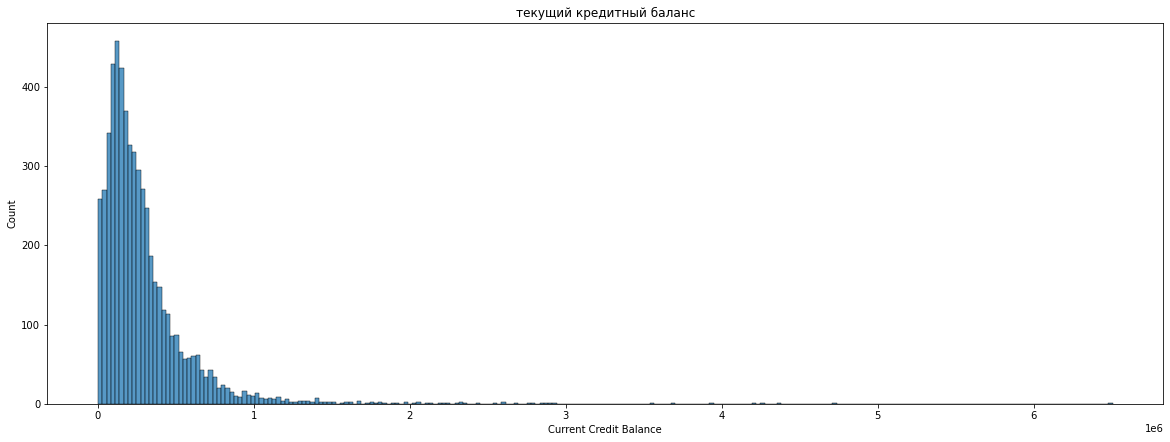

In [243]:
sns.histplot(x_train['Current Credit Balance'])
plt.title('текущий кредитный баланс')

In [244]:
px.box(x_train, y = 'Current Credit Balance') # посмотрим ящик с усами для анализа выбросов

Посмотрим отдельно данные, в которых текущий кредитный баланс больше 3 млн

In [245]:
x_train[x_train['Current Credit Balance']>3000000]

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
3198      1168519.0                  10.0        0.0                     14.0   
162       2131591.0                   0.5        0.0                     15.0   
2618      3199448.0                  10.0        0.0                     11.0   
7278      2418415.0                   6.0        0.0                     13.0   
1580      3783660.0                   1.0        0.0                      9.0   
4602      3990038.0                  10.0        0.0                     10.0   
4769      3739960.0                   9.0        0.0                      7.0   
4745      6029954.0                   4.0        0.0                     30.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
3198                     26.9            5150860.0                        0.0   
162                      31.7            4191176.0                        0.0   
2618                     26.3            5109676.0                        0.0   
7278                     14.0            7453138.0                        0.0   
1580                     17.0            7204516.0                        0.0   
4602                     23.0            9541136.0                        0.0   
4769                     22.8           26343328.0                        0.0   
4745                     17.5           11603856.0                        0.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  \
3198                          49.0           0.0             163680.0   
162                            0.0           0.0             269258.0   
2618                          71.0           0.0             767228.0   
7278                          45.0           0.0             440088.0   
1580                           0.0           0.0             308484.0   
4602                           5.0           0.0             788788.0   
4769                           0.0           0.0             757834.0   
4745                           0.0           0.0             753588.0   

      Current Credit Balance  Monthly Debt  Credit Score Home Ownership  \
3198               3683340.0       75910.0         732.0  Home Mortgage   
162                3547262.0       20783.0         728.0  Home Mortgage   
2618               3927471.0       31461.0         715.0  Home Mortgage   
7278               4209659.0       29626.0         714.0       Own Home   
1580               4249673.0       42251.0         739.0  Home Mortgage   
4602               4367245.0       29792.0         687.0  Home Mortgage   
4769               6506797.0       38023.0         703.0  Home Mortgage   
4745               4720132.0      136679.0         745.0       Own Home   

                 Purpose        Term  
3198   home improvements  Short Term  
162   debt consolidation  Short Term  
2618  debt consolidation  Short Term  
7278  debt consolidation   Long Term  
1580  debt consolidation  Short Term  
4602   home improvements   Long Term  
4769   home improvements  Short Term  
4745  debt consolidation  Short Term

Значения признака текущий кредитный баланс у этих объектов высокое, но не аномальное, принимаем решение оставить данные без изменений

Text(0.5, 1.0, 'Ежемесячный долг')

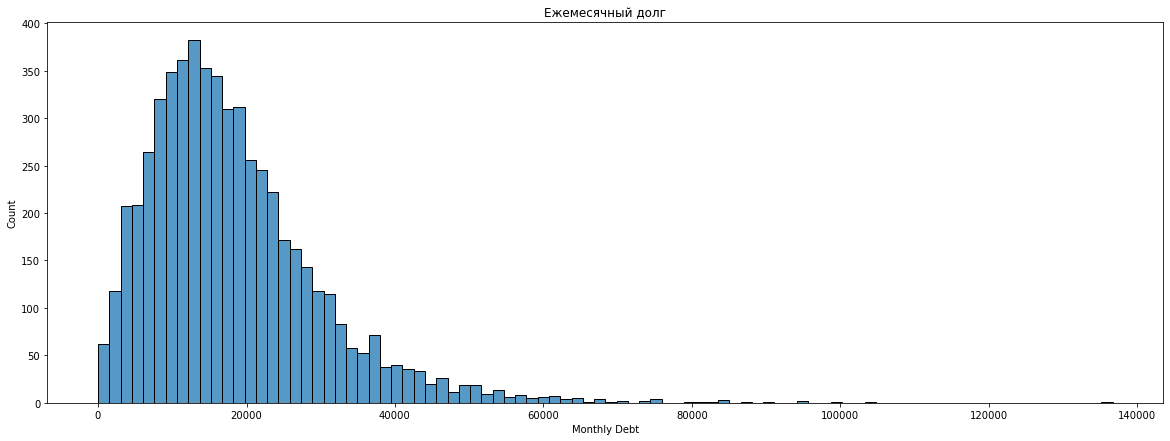

In [246]:
sns.histplot(x_train['Monthly Debt'])
plt.title('Ежемесячный долг')

In [247]:
px.box(x_train, y = 'Monthly Debt') # посмотрим ящик с усами для анализа выбросов

Посмотрим данные, в которых показатель выше 100тыс.

In [248]:
x_train[x_train['Monthly Debt']>100000]

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
2535      4120226.0                  10.0        0.0                     15.0   
6946      6492395.0                   1.0        0.0                     19.0   
4745      6029954.0                   4.0        0.0                     30.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
2535                     13.0            3931620.0                        0.0   
6946                     26.0            1406526.0                        0.0   
4745                     17.5           11603856.0                        0.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  \
2535                           0.0           0.0             542146.0   
6946                           0.0           0.0             322190.0   
4745                           0.0           0.0             753588.0   

      Current Credit Balance  Monthly Debt  Credit Score Home Ownership  \
2535               2889577.0      104036.0         656.0  Home Mortgage   
6946               1169773.0      100091.0         707.0       Own Home   
4745               4720132.0      136679.0         745.0       Own Home   

                 Purpose        Term  
2535  debt consolidation   Long Term  
6946               other  Short Term  
4745  debt consolidation  Short Term

Данные не аномальные, оставляем без изменений

Text(0.5, 1.0, 'Баллы кредитного рейтинга')

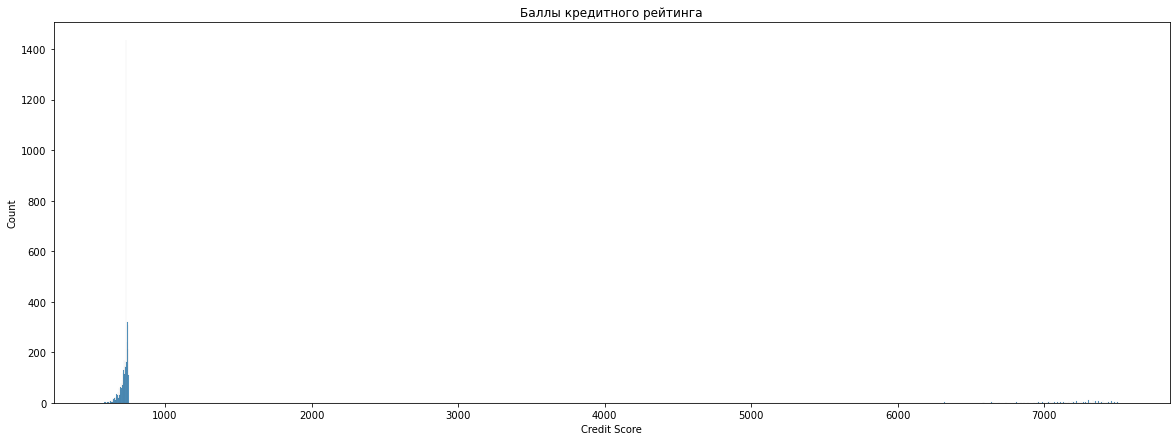

In [249]:
sns.histplot(x_train['Credit Score'])
plt.title('Баллы кредитного рейтинга')

In [250]:
px.box(x_train, y = 'Credit Score') # посмотрим ящик с усами для анализа выбросов

Часть значений выше 6000 при upper fence 751. Данные необходимо проверить

Посмотрим на график зависимости Credit Default от Credit Score в исходном датасете

<AxesSubplot:xlabel='Credit Score', ylabel='Credit Default'>

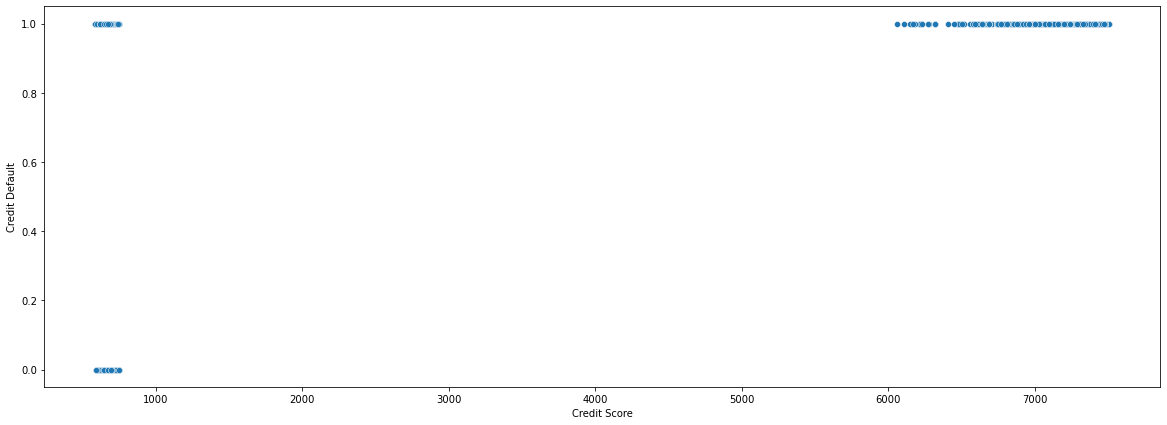

In [251]:
sns.scatterplot(data = df, x = 'Credit Score', y = 'Credit Default')

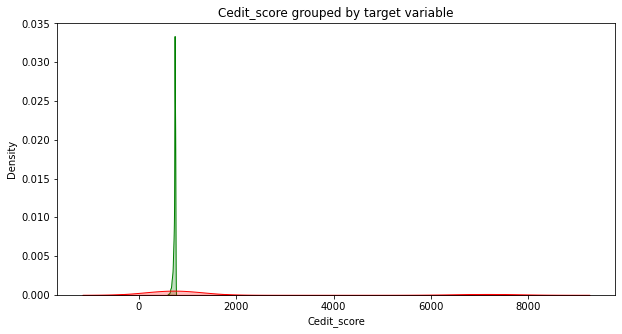

In [252]:
credit_score_with_target = pd.concat([x_train['Credit Score'], y_train], axis = 1)

credit_score = credit_score_with_target['Credit Score']
credit_score_target_0 = credit_score[credit_score_with_target['Credit Default'] == 0]
credit_score_target_1 = credit_score[credit_score_with_target['Credit Default'] == 1]

plt.figure(figsize=(10, 5))

sns.kdeplot(credit_score_target_0, shade=True, label='No default', color='g')
sns.kdeplot(credit_score_target_1, shade=True, label='Default', color='r')

plt.xlabel('Cedit_score')
plt.title('Cedit_score grouped by target variable')
plt.show()

In [253]:
np.sort(df['Credit Score'].unique()) #посмотрим разброс уникальных значений credit score

array([ 585.,  586.,  588.,  589.,  590.,  591.,  593.,  594.,  597.,
        598.,  599.,  601.,  602.,  604.,  606.,  607.,  608.,  609.,
        610.,  611.,  612.,  613.,  614.,  615.,  616.,  617.,  618.,
        619.,  620.,  621.,  622.,  624.,  625.,  626.,  627.,  628.,
        629.,  630.,  631.,  632.,  633.,  634.,  635.,  636.,  637.,
        638.,  639.,  640.,  642.,  643.,  644.,  645.,  646.,  647.,
        648.,  649.,  650.,  651.,  652.,  653.,  654.,  655.,  656.,
        657.,  658.,  659.,  660.,  661.,  662.,  663.,  664.,  665.,
        666.,  667.,  668.,  669.,  670.,  671.,  672.,  673.,  674.,
        675.,  676.,  677.,  678.,  679.,  680.,  681.,  682.,  683.,
        684.,  685.,  686.,  687.,  688.,  689.,  690.,  691.,  692.,
        693.,  694.,  695.,  696.,  697.,  698.,  699.,  700.,  701.,
        702.,  703.,  704.,  705.,  706.,  707.,  708.,  709.,  710.,
        711.,  712.,  713.,  714.,  715.,  716.,  717.,  718.,  719.,
        720.,  721.,

Прослеживается явная прямая связь между большим показателем Credit Score и наличием 1 по Credit Default, значит этот показатель важен именно в таком виде. Изменять или убирать большие значения не нужно. 

### Посмотрим тепловую карту взаимной корреляции признаков.

<AxesSubplot:>

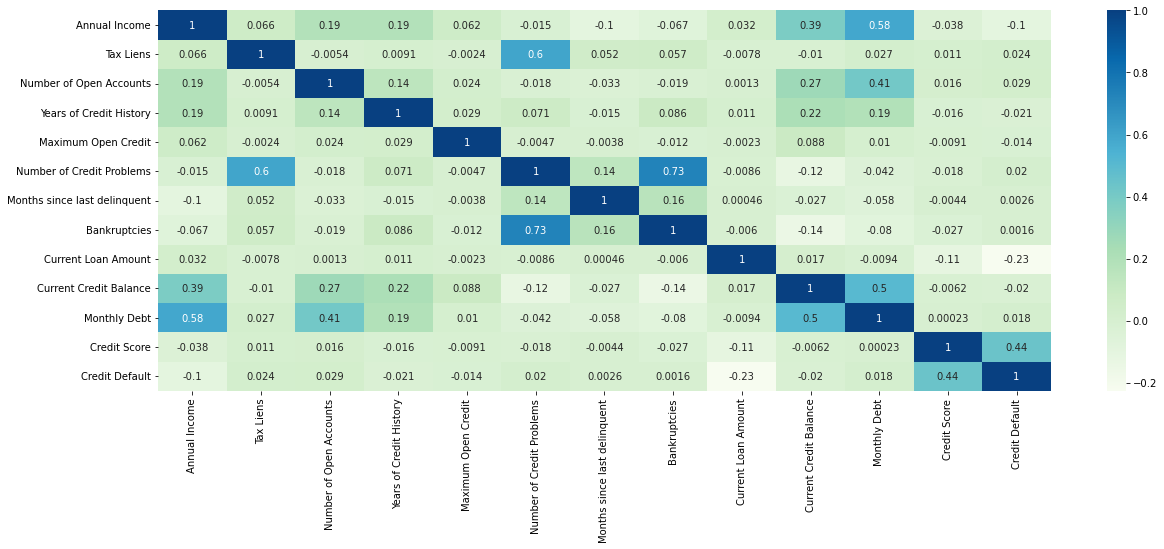

In [254]:
sns.heatmap(df.corr(), annot = True, cmap = 'GnBu')

Скоррелированными признаками являются Number of credit problems и Bankruptcies, это взаимосвязанные признаки. Коэффициент корреляции 0,73. Самым скоррелированным с целевым значением признаком являеется Credit Score (коэффициент корреляции 0,44).

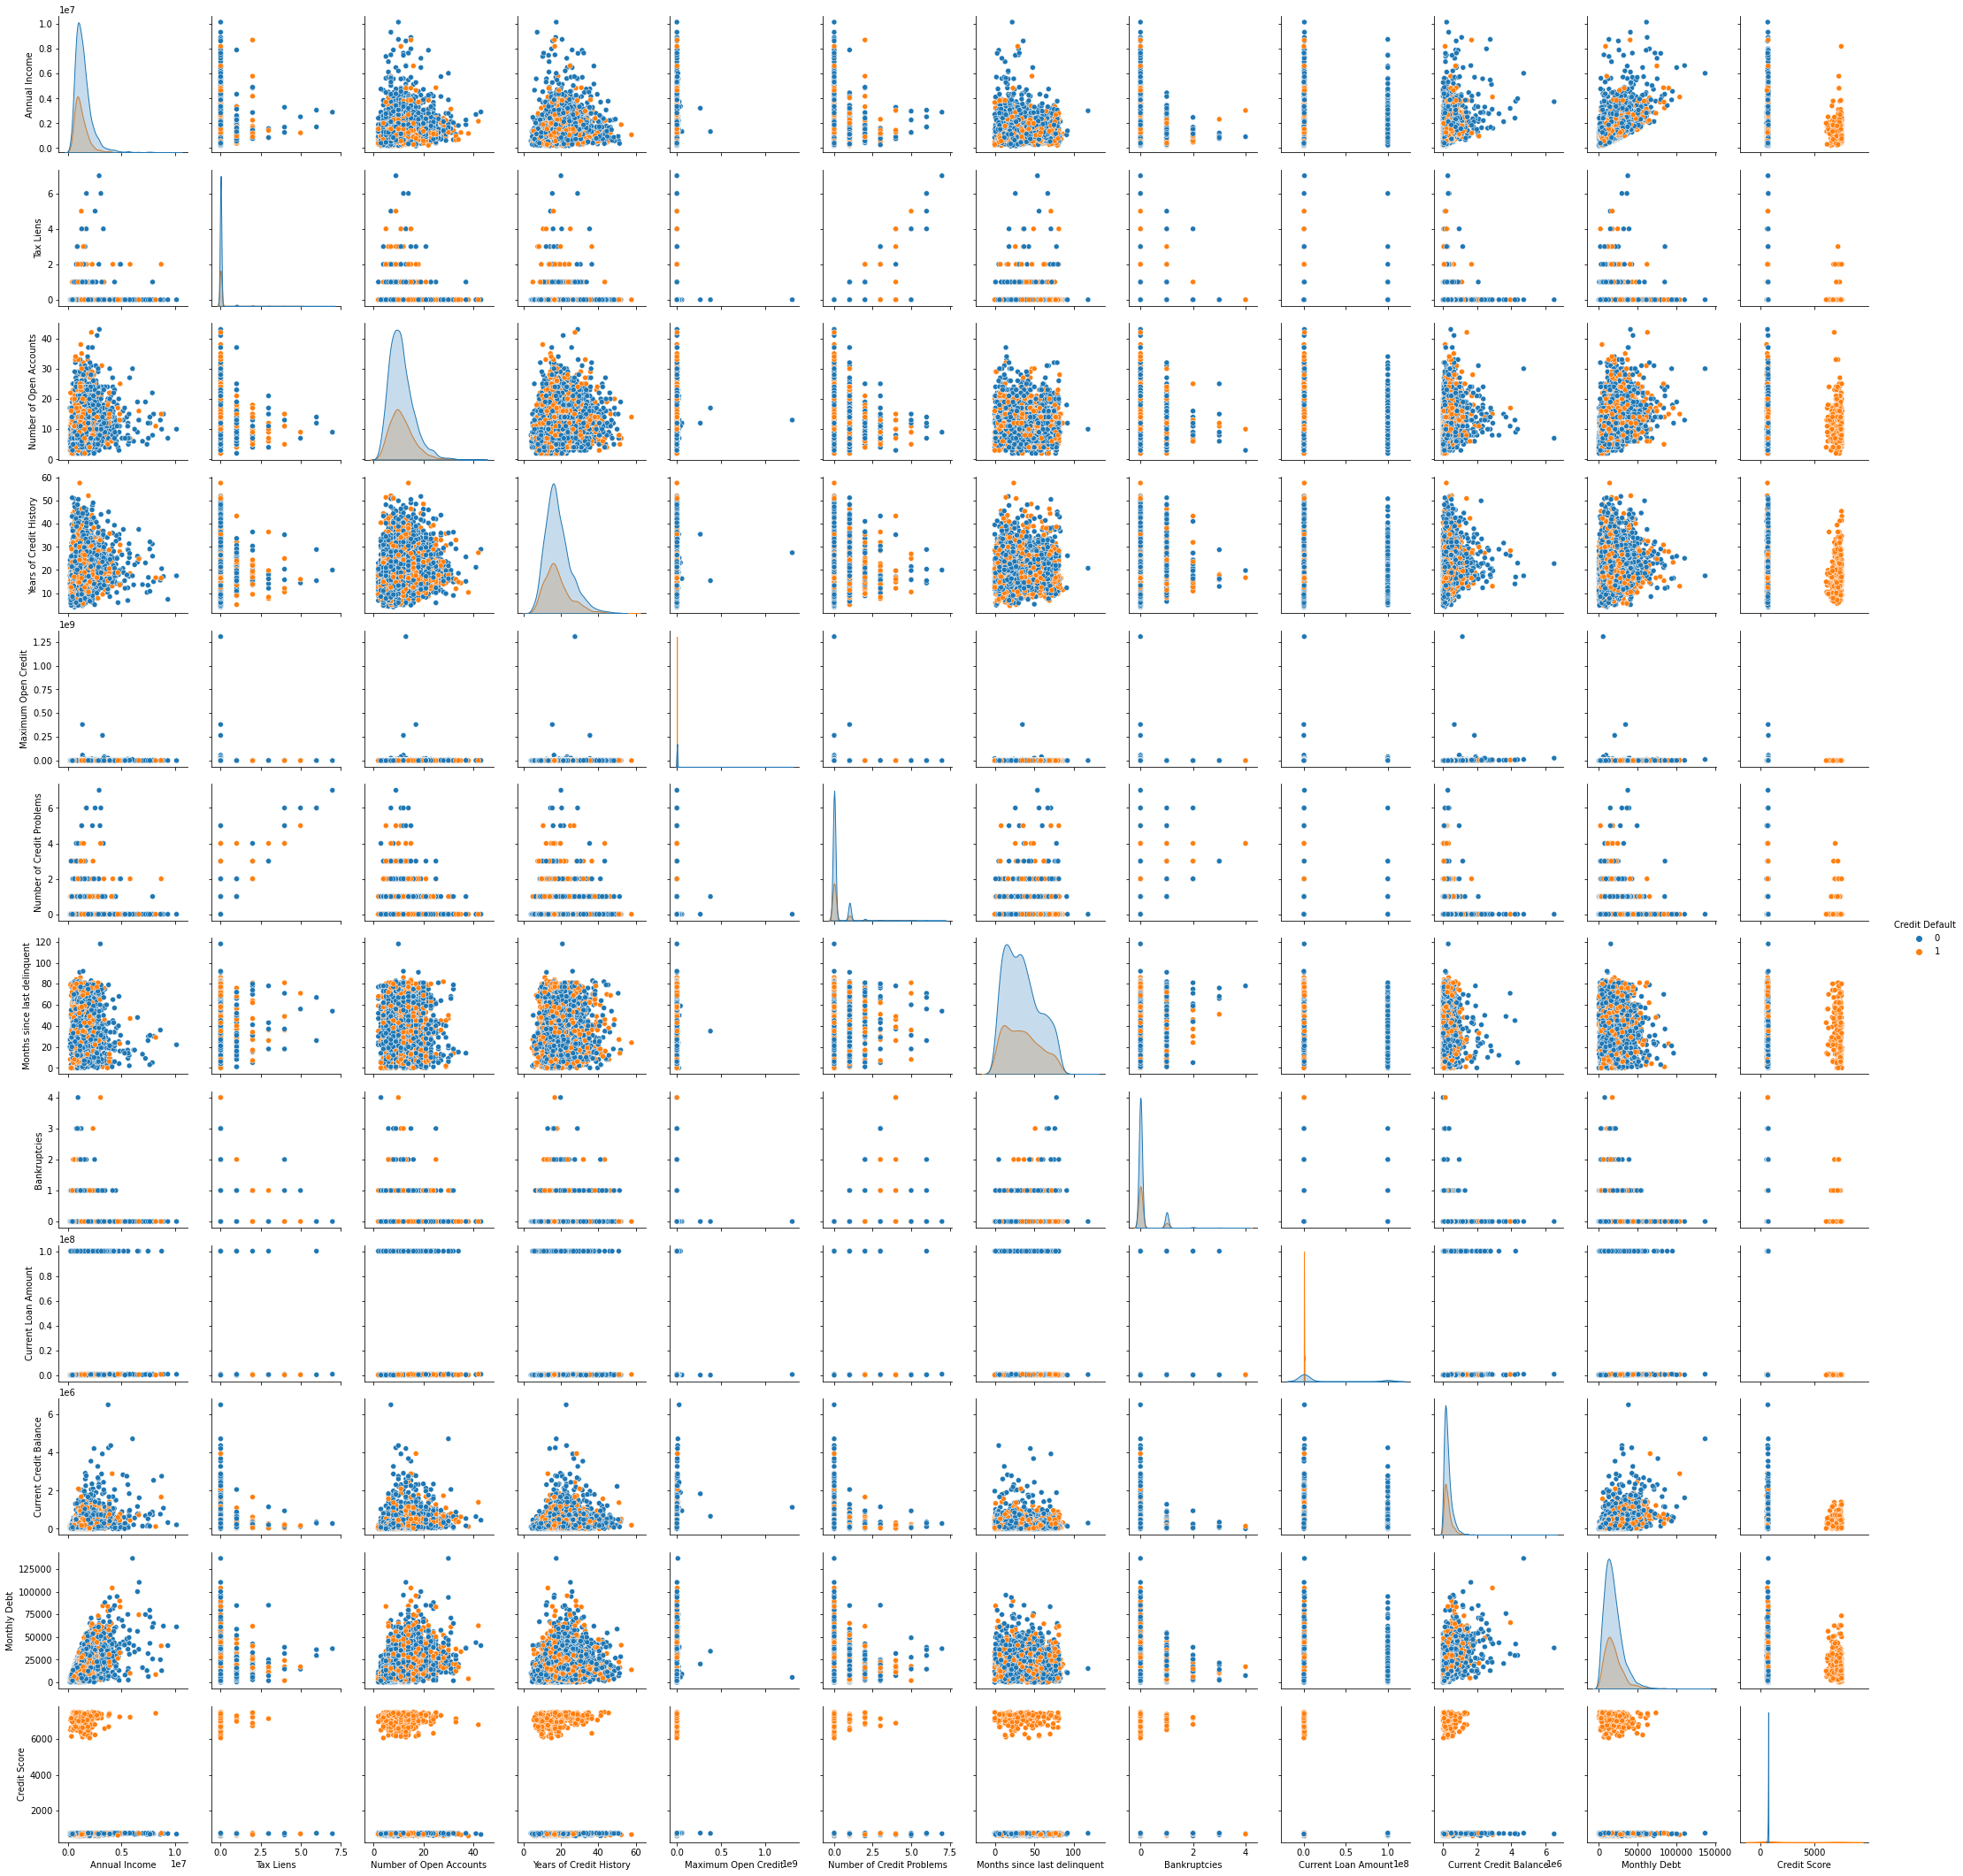

In [255]:
sns.pairplot(df, hue = 'Credit Default')

На группе графиков взаимозависимости признаков видно, что при больших значениях показателя credit score значение credit default всегда равно 1.

### Балансировка классов

In [256]:
df_for_balancing = pd.concat([x_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    4054
1    3136
Name: Credit Default, dtype: int64

In [257]:
df_balanced.shape

(7190, 17)

In [258]:
x_train_balanced = df_balanced[FEATURE_NAMES]
y_train_balanced = df_balanced[TARGET_NAME]

In [259]:
x_train_balanced.shape, y_train_balanced.shape

((7190, 16), (7190,))

### One hot encoding для моделей, не поддерживающих категориальные признаки

In [260]:
x_train_balanced[CAT_FEATURE_NAMES].columns

Index(['Home Ownership', 'Purpose', 'Term'], dtype='object')

In [261]:
for cat_colname in x_train_balanced.select_dtypes(include='category').columns:
    x_train_balanced = pd.concat([x_train_balanced, pd.get_dummies(x_train_balanced[cat_colname], prefix=cat_colname)], axis=1)

In [262]:
x_train_balanced.head()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
2617      1299543.0                   8.0        0.0                     14.0   
3462       959880.0                   6.0        0.0                     14.0   
769       1021174.0                   1.0        0.0                      8.0   
1437      1869030.0                  10.0        0.0                      8.0   
3274      1168519.0                  10.0        0.0                      8.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
2617                     15.8             582450.0                        0.0   
3462                     26.4             422532.0                        0.0   
769                      17.5             608762.0                        0.0   
1437                     27.3             149424.0                        1.0   
3274                     16.9             413600.0                        0.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  ...  \
2617                          33.0           0.0             672826.0  ...   
3462                           0.0           0.0             188936.0  ...   
769                            0.0           0.0              81686.0  ...   
1437                          38.0           1.0              41118.0  ...   
3274                           0.0           0.0             393272.0  ...   

      Purpose_medical bills  Purpose_moving  Purpose_other  \
2617                      0               0              0   
3462                      0               0              1   
769                       0               0              0   
1437                      0               0              0   
3274                      0               0              0   

     Purpose_renewable energy Purpose_small business Purpose_take a trip  \
2617                        0                      0                   0   
3462                        0                      0                   0   
769                         0                      0                   0   
1437                        0                      0                   0   
3274                        0                      0                   0   

      Purpose_vacation  Purpose_wedding  Term_Long Term  Term_Short Term  
2617                 0                0               0                1  
3462                 0                0               0                1  
769                  0                0               0                1  
1437                 0                0               0                1  
3274                 0                0               1                0  

[5 rows x 37 columns]

In [263]:
x_train_balanced.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score',
       'Home Ownership', 'Purpose', 'Term', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
       'Term_Long Term', 'Term_Short Term'],
      dtype='object')

In [264]:
scaler = StandardScaler()

In [265]:
x_train_balanced_scaled =  pd.concat([pd.DataFrame(scaler.fit_transform(x_train_balanced[['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']]), columns = ['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']), x_train_balanced.drop(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score'], axis = 1)],axis=1)

In [266]:
x_train_balanced_scaled.head()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
0      -0.002054              0.612521   -0.11912                 0.572155   
1      -0.470567              0.033653   -0.11912                 0.572155   
2      -0.386022             -1.413516   -0.11912                -0.649220   
3       0.783466              1.191388   -0.11912                -0.649220   
4      -0.182782              1.191388   -0.11912                -0.649220   

   Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                -0.353963            -0.068148                  -0.338951   
1                 1.144871            -0.196901                  -0.338951   
2                -0.113584            -0.046963                  -0.338951   
3                 1.272130            -0.416785                   1.606026   
4                -0.198423            -0.204092                  -0.338951   

   Months since last delinquent  Bankruptcies  Current Loan Amount  ...  \
0                      0.751116     -0.338603             2.076860  ...   
1                     -0.703648     -0.338603            -0.709529  ...   
2                     -0.703648     -0.338603            -1.327107  ...   
3                      0.971534      2.587544            -1.560711  ...   
4                     -0.703648     -0.338603             0.467101  ...   

   Purpose_medical bills  Purpose_moving  Purpose_other  \
0                      0               0              0   
1                      0               0              0   
2                      0               0              0   
3                      0               0              0   
4                      0               0              0   

  Purpose_renewable energy Purpose_small business Purpose_take a trip  \
0                        0                      0                   0   
1                        0                      0                   0   
2                        0                      0                   0   
3                        0                      0                   0   
4                        0                      0                   0   

   Purpose_vacation  Purpose_wedding  Term_Long Term  Term_Short Term  
0                 0                0               0                1  
1                 0                0               0                1  
2                 0                0               0                1  
3                 0                0               1                0  
4                 0                0               0                1  

[5 rows x 37 columns]

In [267]:
x_train_balanced_scaled.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score',
       'Home Ownership', 'Purpose', 'Term', 'Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
       'Term_Long Term', 'Term_Short Term'],
      dtype='object')

Применим метод TSNE для визуализации обучающего датасета в двухмерном пространстве

In [268]:
tsne = TSNE(n_components = 2, learning_rate = 200, random_state = 100)

In [269]:
x_train_tsne = tsne.fit_transform(x_train_balanced_scaled.drop(CAT_FEATURE_NAMES, axis = 1))

<AxesSubplot:>

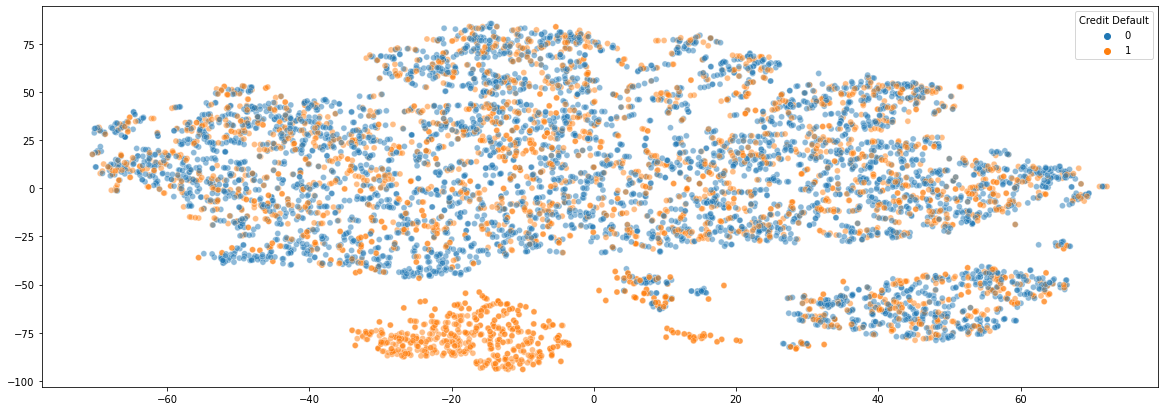

In [270]:
sns.scatterplot(data = x_train_tsne, x = x_train_tsne[:, 0], y = x_train_tsne[:, 1], hue = y_train_balanced, alpha = 0.5)

Видим, что на карте визуализации есть сформированный кластер 1го класса. Добавим в датасет кластеризацию K-means

Подберем оптимальное количество кластеров

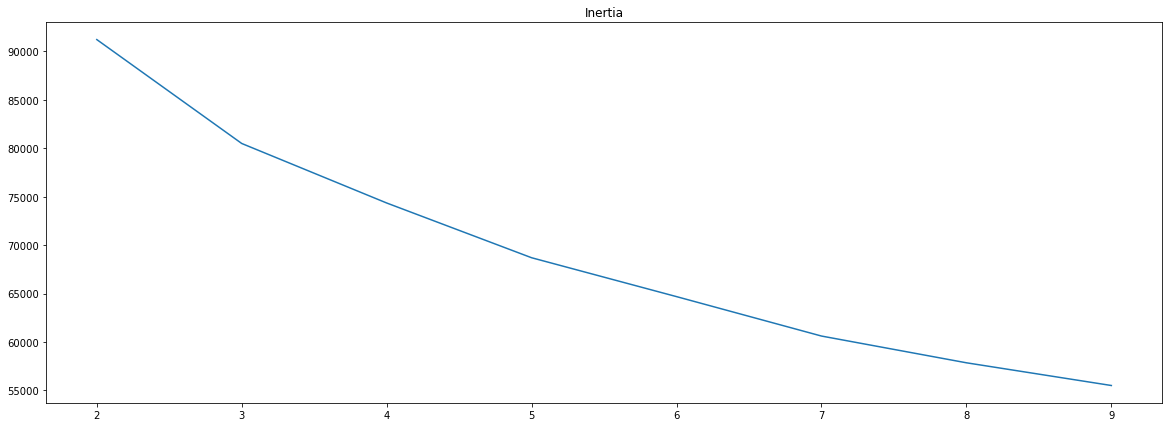

In [271]:
inertias = []

for i in range(2, 10):
    temp_model = KMeans(n_clusters=i, random_state=100)
    temp_model.fit(x_train_balanced_scaled.drop(CAT_FEATURE_NAMES, axis = 1))
    
    temp_inertia = temp_model.inertia_
    
    inertias.append(temp_inertia)

plt.plot(range(2, 10), inertias)

plt.title('Inertia')

plt.show()

In [272]:
train_labels = []
for i in [3, 4, 6]:
    km_model = KMeans(n_clusters=i, random_state=100)
    train_labels.append(km_model.fit_predict(x_train_balanced_scaled.drop(CAT_FEATURE_NAMES, axis = 1)))

In [273]:
train_labels_3 = train_labels[0]
train_labels_4 = train_labels[1]
train_labels_6 = train_labels[2]

<AxesSubplot:>

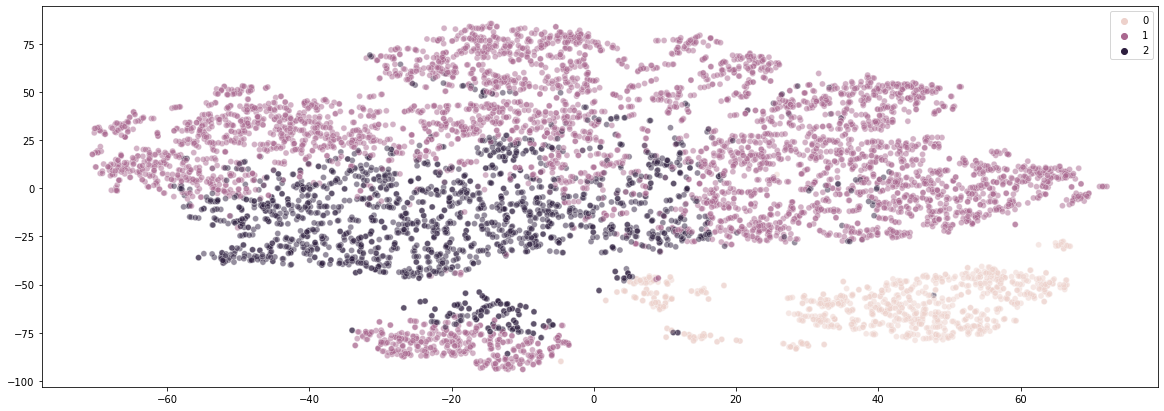

In [274]:
sns.scatterplot(data = x_train_tsne, x = x_train_tsne[:, 0], y = x_train_tsne[:, 1], hue = train_labels_3, alpha = 0.5)

<AxesSubplot:>

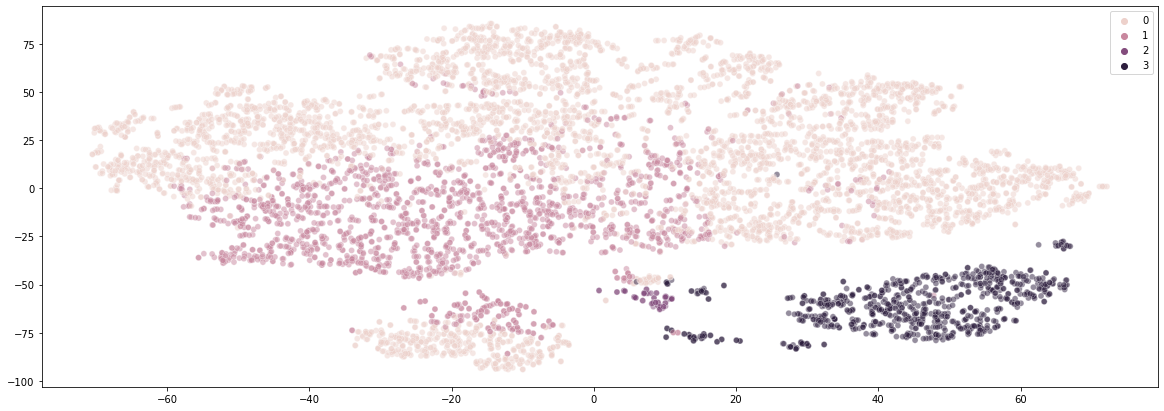

In [275]:
sns.scatterplot(data = x_train_tsne, x = x_train_tsne[:, 0], y = x_train_tsne[:, 1], hue = train_labels_4, alpha = 0.5)

<AxesSubplot:>

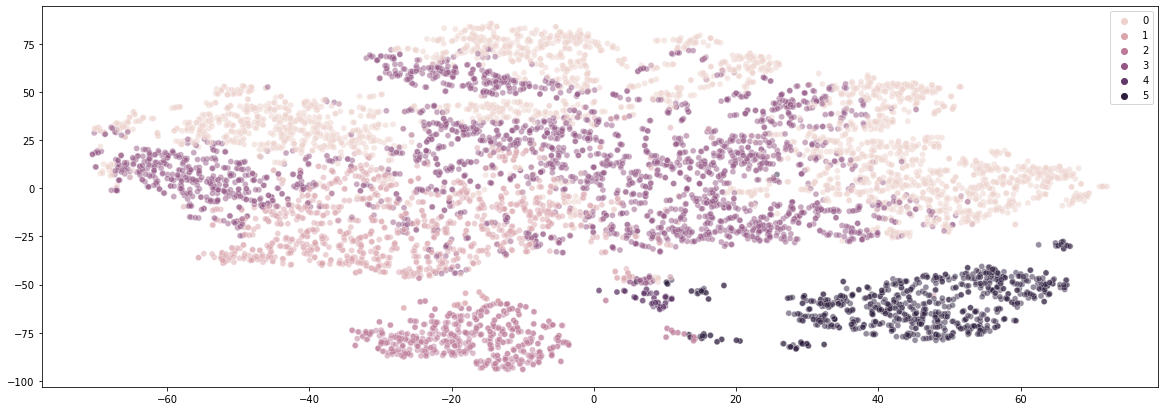

In [276]:
sns.scatterplot(data = x_train_tsne, x = x_train_tsne[:, 0], y = x_train_tsne[:, 1], hue = train_labels_6, alpha = 0.5)

In [277]:
# добавим в датасет кластеризацию на 3, 4 и 6 кластеров
x_train_balanced_scaled['labels_3'], x_train_balanced_scaled['labels_4'], x_train_balanced_scaled['labels_6'] = train_labels_3, train_labels_4, train_labels_6

In [278]:
x_train_balanced_scaled.head()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
0      -0.002054              0.612521   -0.11912                 0.572155   
1      -0.470567              0.033653   -0.11912                 0.572155   
2      -0.386022             -1.413516   -0.11912                -0.649220   
3       0.783466              1.191388   -0.11912                -0.649220   
4      -0.182782              1.191388   -0.11912                -0.649220   

   Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                -0.353963            -0.068148                  -0.338951   
1                 1.144871            -0.196901                  -0.338951   
2                -0.113584            -0.046963                  -0.338951   
3                 1.272130            -0.416785                   1.606026   
4                -0.198423            -0.204092                  -0.338951   

   Months since last delinquent  Bankruptcies  Current Loan Amount  ...  \
0                      0.751116     -0.338603             2.076860  ...   
1                     -0.703648     -0.338603            -0.709529  ...   
2                     -0.703648     -0.338603            -1.327107  ...   
3                      0.971534      2.587544            -1.560711  ...   
4                     -0.703648     -0.338603             0.467101  ...   

   Purpose_renewable energy  Purpose_small business  Purpose_take a trip  \
0                         0                       0                    0   
1                         0                       0                    0   
2                         0                       0                    0   
3                         0                       0                    0   
4                         0                       0                    0   

  Purpose_vacation Purpose_wedding Term_Long Term  Term_Short Term  labels_3  \
0                0               0              0                1         2   
1                0               0              0                1         1   
2                0               0              0                1         1   
3                0               0              1                0         0   
4                0               0              0                1         1   

   labels_4  labels_6  
0         1         3  
1         0         3  
2         0         0  
3         3         5  
4         0         3  

[5 rows x 40 columns]

Добавим в датасет 2 компоненты, полученные при понижении размерности PCA

In [279]:
pca = PCA(n_components=2, random_state=100)

In [280]:
components_train = pca.fit_transform(x_train_balanced_scaled.drop(CAT_FEATURE_NAMES, axis = 1))

In [281]:
x_train_balanced_scaled[['comp1', 'comp2']] = components_train

In [282]:
x_train_balanced_scaled.head()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
0      -0.002054              0.612521   -0.11912                 0.572155   
1      -0.470567              0.033653   -0.11912                 0.572155   
2      -0.386022             -1.413516   -0.11912                -0.649220   
3       0.783466              1.191388   -0.11912                -0.649220   
4      -0.182782              1.191388   -0.11912                -0.649220   

   Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                -0.353963            -0.068148                  -0.338951   
1                 1.144871            -0.196901                  -0.338951   
2                -0.113584            -0.046963                  -0.338951   
3                 1.272130            -0.416785                   1.606026   
4                -0.198423            -0.204092                  -0.338951   

   Months since last delinquent  Bankruptcies  Current Loan Amount  ...  \
0                      0.751116     -0.338603             2.076860  ...   
1                     -0.703648     -0.338603            -0.709529  ...   
2                     -0.703648     -0.338603            -1.327107  ...   
3                      0.971534      2.587544            -1.560711  ...   
4                     -0.703648     -0.338603             0.467101  ...   

   Purpose_take a trip  Purpose_vacation  Purpose_wedding Term_Long Term  \
0                    0                 0                0              0   
1                    0                 0                0              0   
2                    0                 0                0              0   
3                    0                 0                0              1   
4                    0                 0                0              0   

  Term_Short Term labels_3  labels_4  labels_6     comp1     comp2  
0               1        2         1         3  0.793040  1.457254  
1               1        1         0         3  0.463959 -0.539225  
2               1        1         0         0 -2.214429 -1.403712  
3               0        0         3         5  5.220767 -1.142973  
4               1        1         0         3  0.456431 -0.388919  

[5 rows x 42 columns]

In [283]:
x_train_balanced_scaled.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7190 entries, 0 to 7189
Data columns (total 42 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   Annual Income                 7190 non-null   float64 
 1   Years in current job          7190 non-null   float64 
 2   Tax Liens                     7190 non-null   float64 
 3   Number of Open Accounts       7190 non-null   float64 
 4   Years of Credit History       7190 non-null   float64 
 5   Maximum Open Credit           7190 non-null   float64 
 6   Number of Credit Problems     7190 non-null   float64 
 7   Months since last delinquent  7190 non-null   float64 
 8   Bankruptcies                  7190 non-null   float64 
 9   Current Loan Amount           7190 non-null   float64 
 10  Current Credit Balance        7190 non-null   float64 
 11  Monthly Debt                  7190 non-null   float64 
 12  Credit Score                  7190 non-null   fl

In [284]:
#обучающие данные для модели CATboost
x_train_balanced_scaled_CAT = x_train_balanced_scaled.drop(['Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
       'Term_Long Term', 'Term_Short Term'], axis = 1)

In [285]:
#обучающие данные для моделей кроме CATboost
x_train_balanced_scaled_NO_CAT = x_train_balanced_scaled.drop(CAT_FEATURE_NAMES, axis = 1)

In [286]:
#Функция для приведения тестовых данных в соответствие тренировочным
def test_transform(df):
    
    df = df.reset_index(drop=True)

    df = cat_int(df)
    df = fill_nan(df)
    df.loc[df['Current Loan Amount']>1000000, 'Current Loan Amount'] = med_curr_loan_amount
    
    #one hot
    for cat_colname in df.select_dtypes(include='category').columns:
        df = pd.concat([df, pd.get_dummies(df[cat_colname], prefix=cat_colname)], axis=1)
        
    
    #scaler
    df =  pd.concat([pd.DataFrame(scaler.transform(df[['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']]), columns = ['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score']), df.drop(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score'], axis = 1)],axis=1)
    
    # добавление отсутствующих столбцов
    
    for el in list(x_train_balanced_scaled.drop(['labels_3', 'labels_4', 'labels_6', 'comp1', 'comp2']+CAT_FEATURE_NAMES, axis = 1).columns):
        if el not in list(df.columns):
            df[el] = 0
    
    # Kmeans добавим в тестовый датасет
       
    valid_labels = []
    for i in [3, 4, 6]:
        km_model = KMeans(n_clusters=i, random_state=100)
        km_model.fit(x_train_balanced_scaled.drop(['labels_3', 'labels_4', 'labels_6', 'comp1', 'comp2']+CAT_FEATURE_NAMES, axis = 1))
        valid_labels.append(km_model.predict(df.drop(CAT_FEATURE_NAMES, axis = 1)))
    valid_labels_3 = valid_labels[0]
    valid_labels_4 = valid_labels[1]
    valid_labels_6 = valid_labels[2]
    df['labels_3'], df['labels_4'], df['labels_6'] = valid_labels_3, valid_labels_4, valid_labels_6
    
    # pca
    components_valid = pca.transform(df.drop(CAT_FEATURE_NAMES, axis = 1))
    df[['comp1', 'comp2']] = components_valid
    
    df_CAT = df.drop(['Home Ownership_Have Mortgage',
       'Home Ownership_Home Mortgage', 'Home Ownership_Own Home',
       'Home Ownership_Rent', 'Purpose_business loan', 'Purpose_buy a car',
       'Purpose_buy house', 'Purpose_debt consolidation',
       'Purpose_educational expenses', 'Purpose_home improvements',
       'Purpose_major purchase', 'Purpose_medical bills', 'Purpose_moving',
       'Purpose_other', 'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
       'Term_Long Term', 'Term_Short Term'], axis = 1)
    df_NO_CAT = df.drop(CAT_FEATURE_NAMES, axis = 1)
    
    
    return df_CAT, df_NO_CAT

Проведем преобразования отложенной выборки для приведления ее в соответствие с обучающей

In [287]:
x_valid.head()

Annual Income Years in current job  Tax Liens  Number of Open Accounts  \
6925      1313242.0              2 years        0.0                      9.0   
5312      1043670.0              3 years        0.0                      7.0   
7274      1163712.0              5 years        0.0                      7.0   
3488       635094.0                  NaN        0.0                     10.0   
1142      1640042.0              6 years        0.0                     10.0   

      Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
6925                     19.8             467346.0                        0.0   
5312                     17.0             567886.0                        0.0   
7274                     14.3             623744.0                        0.0   
3488                     26.8             457292.0                        1.0   
1142                      6.6             690250.0                        0.0   

      Months since last delinquent  Bankruptcies  Current Loan Amount  \
6925                          41.0           0.0             217228.0   
5312                           NaN           0.0             345268.0   
7274                          74.0           0.0             269500.0   
3488                           NaN           1.0             245498.0   
1142                           NaN           0.0             536184.0   

      Current Credit Balance  Monthly Debt  Credit Score Home Ownership  \
6925                181222.0       26593.0         670.0  Home Mortgage   
5312                373730.0       18003.0         653.0           Rent   
7274                166991.0       15807.0         732.0           Rent   
3488                177707.0       15613.0         711.0  Home Mortgage   
1142                481061.0       32664.0        7120.0           Rent   

                 Purpose        Term  
6925           buy house  Short Term  
5312  debt consolidation   Long Term  
7274  debt consolidation  Short Term  
3488  debt consolidation   Long Term  
1142  debt consolidation   Long Term

In [288]:
x_valid_CAT, x_valid_NO_CAT = test_transform(x_valid)

In [289]:
y_valid = y_valid.reset_index(drop=True)

In [290]:
x_valid_CAT.head()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
0       0.016841             -1.124082   -0.11912                -0.445658   
1      -0.354992             -0.834648   -0.11912                -0.852783   
2      -0.189412             -0.255781   -0.11912                -0.852783   
3      -0.918560              0.033653   -0.11912                -0.242095   
4       0.467612              0.033653   -0.11912                -0.242095   

   Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                 0.211635            -0.160820                  -0.338951   
1                -0.184283            -0.079873                  -0.338951   
2                -0.566062            -0.034901                  -0.338951   
3                 1.201431            -0.168915                   1.606026   
4                -1.654837             0.018644                  -0.338951   

   Months since last delinquent  Bankruptcies  Current Loan Amount  ...  \
0                      1.103786     -0.338603            -0.546615  ...   
1                     -0.703648     -0.338603             0.190679  ...   
2                      2.558549     -0.338603            -0.245616  ...   
3                     -0.703648      2.587544            -0.383827  ...   
4                     -0.703648     -0.338603             1.290033  ...   

   Monthly Debt  Credit Score  Home Ownership             Purpose        Term  \
0      0.704590     -0.333849   Home Mortgage           buy house  Short Term   
1     -0.024241     -0.343364            Rent  debt consolidation   Long Term   
2     -0.210564     -0.299146            Rent  debt consolidation  Short Term   
3     -0.227024     -0.310900   Home Mortgage  debt consolidation   Long Term   
4      1.219693      3.276416            Rent  debt consolidation   Long Term   

  labels_3  labels_4  labels_6     comp1     comp2  
0        1         0         0 -1.867238 -0.367723  
1        1         0         0 -2.089706 -0.409966  
2        1         0         3  0.446001 -0.875873  
3        0         3         5  4.828917 -1.051647  
4        2         1         2 -0.353348  1.401435  

[5 rows x 21 columns]

In [291]:
x_valid_NO_CAT.head()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
0       0.016841             -1.124082   -0.11912                -0.445658   
1      -0.354992             -0.834648   -0.11912                -0.852783   
2      -0.189412             -0.255781   -0.11912                -0.852783   
3      -0.918560              0.033653   -0.11912                -0.242095   
4       0.467612              0.033653   -0.11912                -0.242095   

   Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                 0.211635            -0.160820                  -0.338951   
1                -0.184283            -0.079873                  -0.338951   
2                -0.566062            -0.034901                  -0.338951   
3                 1.201431            -0.168915                   1.606026   
4                -1.654837             0.018644                  -0.338951   

   Months since last delinquent  Bankruptcies  Current Loan Amount  ...  \
0                      1.103786     -0.338603            -0.546615  ...   
1                     -0.703648     -0.338603             0.190679  ...   
2                      2.558549     -0.338603            -0.245616  ...   
3                     -0.703648      2.587544            -0.383827  ...   
4                     -0.703648     -0.338603             1.290033  ...   

   Purpose_take a trip  Purpose_vacation  Purpose_wedding  Term_Long Term  \
0                    0                 0                0               0   
1                    0                 0                0               1   
2                    0                 0                0               0   
3                    0                 0                0               1   
4                    0                 0                0               1   

   Term_Short Term  labels_3  labels_4  labels_6     comp1     comp2  
0                1         1         0         0 -1.867238 -0.367723  
1                0         1         0         0 -2.089706 -0.409966  
2                1         1         0         3  0.446001 -0.875873  
3                0         0         3         5  4.828917 -1.051647  
4                0         2         1         2 -0.353348  1.401435  

[5 rows x 39 columns]

# Обучение модели

В ходе подготовки проекта было протестировано несколько моделей, привожу их в проекте в закомментированном виде. Основной моделью оставляем XGBoost.

In [292]:
# cat_model = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)

# cat_model.fit(x_train_balanced_scaled_CAT, y_train_balanced, cat_features =['Home Ownership', 'Purpose', 'Term'])

# y_train_pred = cat_model.predict(x_train_balanced_scaled_CAT)
# y_valid_pred = cat_model.predict(x_valid_CAT)
# y_valid_pred_probs = cat_model.predict_proba(x_valid_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

In [293]:
# Первичная проверка работы модели без подбора параметров
XGBclf = XGBClassifier(random_state=21)

XGBclf.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

y_train_pred = XGBclf.predict(x_train_balanced_scaled_NO_CAT)
y_valid_pred = XGBclf.predict(x_valid_NO_CAT)
y_valid_pred_probs = XGBclf.predict_proba(x_valid_NO_CAT)

get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4054
           1       0.98      0.98      0.98      3136

    accuracy                           0.98      7190
   macro avg       0.98      0.98      0.98      7190
weighted avg       0.98      0.98      0.98      7190

TEST

              precision    recall  f1-score   support

           0       0.78      0.86      0.82      1330
           1       0.54      0.40      0.46       545

    accuracy                           0.73      1875
   macro avg       0.66      0.63      0.64      1875
weighted avg       0.71      0.73      0.71      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1146  184
1                326  219


In [294]:
# lgbm_model = lgbm.LGBMClassifier(random_state=21)

# lgbm_model.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

# y_train_pred = lgbm_model.predict(x_train_balanced_scaled_NO_CAT)
# y_valid_pred = lgbm_model.predict(x_valid_NO_CAT)
# y_valid_pred_probs = lgbm_model.predict_proba(x_valid_NO_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

In [295]:
# RFclf = RandomForestClassifier(random_state=21)

# RFclf.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

# y_train_pred = RFclf.predict(x_train_balanced_scaled_NO_CAT)
# y_valid_pred = RFclf.predict(x_valid_NO_CAT)
# y_valid_pred_probs = RFclf.predict_proba(x_valid_NO_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

In [296]:
# log_reg = LogisticRegression(random_state=21)

# log_reg.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

# y_train_pred = log_reg.predict(x_train_balanced_scaled_NO_CAT)
# y_valid_pred = log_reg.predict(x_valid_NO_CAT)
# y_valid_pred_probs = log_reg.predict_proba(x_valid_NO_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

In [297]:
# clf = RidgeClassifier(alpha = 1, random_state=21)

# clf.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

# y_train_pred = clf.predict(x_train_balanced_scaled_NO_CAT)
# y_valid_pred = clf.predict(x_valid_NO_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

In [298]:
# clf = KNeighborsClassifier()

# clf.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

# y_train_pred = clf.predict(x_train_balanced_scaled_NO_CAT)
# y_valid_pred = clf.predict(x_valid_NO_CAT)
# y_valid_pred_probs = clf.predict_proba(x_valid_NO_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

In [299]:
# clf = SVC(random_state=21)

# clf.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

# y_train_pred = clf.predict(x_train_balanced_scaled_NO_CAT)
# y_valid_pred = clf.predict(x_valid_NO_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

In [300]:
# params = {'n_estimators':[500, 1000, 1200, 1500],
#           'max_depth':[3, 5, 7], 'eta':[0.01,0.1], 'reg_lambda':[0.1, 0.5, 3, 5]}

In [301]:
# cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [302]:
# %%time

# rs = RandomizedSearchCV(cat_model, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(x_train_balanced_scaled_CAT, y_train_balanced, cat_features =['Home Ownership', 'Purpose', 'Term'])

In [303]:
# rs.best_params_

In [304]:
# rs.best_score_

Лучшие модели после подбора гипер-параметров

In [305]:
# cat_model = catb.CatBoostClassifier(class_weights=[1, 3.5], reg_lambda = 3, n_estimators = 500, max_depth = 5, eta = 0.1, silent=True, random_state=21)

# cat_model.fit(x_train_balanced_scaled_CAT, y_train_balanced, cat_features =['Home Ownership', 'Purpose', 'Term'])

# y_train_pred = cat_model.predict(x_train_balanced_scaled_CAT)
# y_valid_pred = cat_model.predict(x_valid_CAT)
# y_valid_pred_probs = cat_model.predict_proba(x_valid_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

In [306]:
# show_learning_curve_plot(cat_model, X=x_train_balanced_scaled_NO_CAT, y=y_train_balanced, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

In [307]:
# show_proba_calibration_plots(y_valid_pred_probs[:, 1], y_valid)

In [308]:
# important_features_top = show_feature_importances(x_train_balanced_scaled_CAT.columns, cat_model.feature_importances_, get_top=15)

In [309]:
# params = {'n_estimators':[500, 1000, 1500, 2000, 5000],
#           'max_depth':[3, 5, 7], 'learning_rate':[0.01,0.1]}

In [310]:
# cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [311]:
# %%time

# rs = RandomizedSearchCV(XGBclf, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

In [312]:
# rs.best_params_

In [313]:
# rs.best_score_

In [385]:
XGBclf = XGBClassifier(random_state=21, n_estimators=500, max_depth=5, eta=0.01, gamma = 0.1, alpha = 5)

XGBclf.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

y_train_pred = XGBclf.predict(x_train_balanced_scaled_NO_CAT)
y_train_pred_probs = XGBclf.predict_proba(x_train_balanced_scaled_NO_CAT)
y_valid_pred = XGBclf.predict(x_valid_NO_CAT)
y_valid_pred_probs = XGBclf.predict_proba(x_valid_NO_CAT)

get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.73      0.90      0.80      4054
           1       0.81      0.56      0.66      3136

    accuracy                           0.75      7190
   macro avg       0.77      0.73      0.73      7190
weighted avg       0.76      0.75      0.74      7190

TEST

              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1330
           1       0.59      0.47      0.52       545

    accuracy                           0.75      1875
   macro avg       0.70      0.67      0.68      1875
weighted avg       0.74      0.75      0.74      1875

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1154  176
1                289  256


Посмотрим динамику кривой обучения в зависимости от тобъема выборки

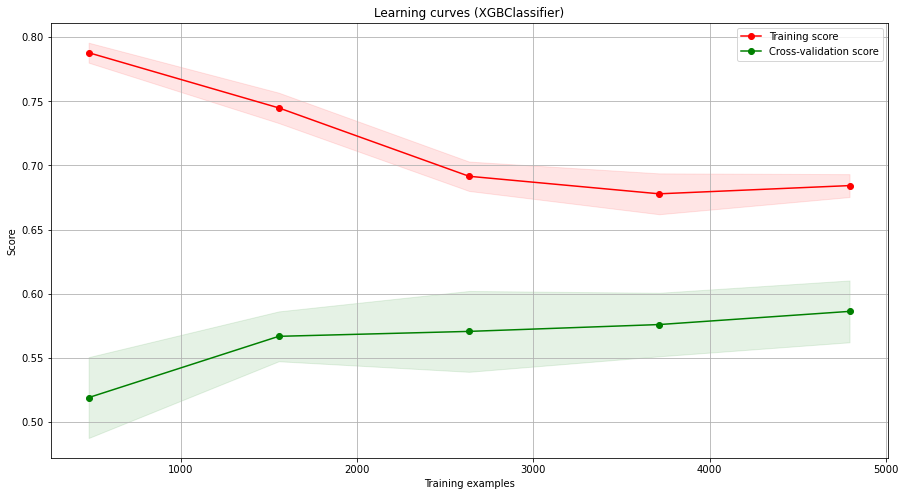

In [386]:
show_learning_curve_plot(XGBclf, X=x_train_balanced_scaled_NO_CAT, y=y_train_balanced, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))

Посмотрим лучшие пороги вероятности для отнесения к 1 кклассу

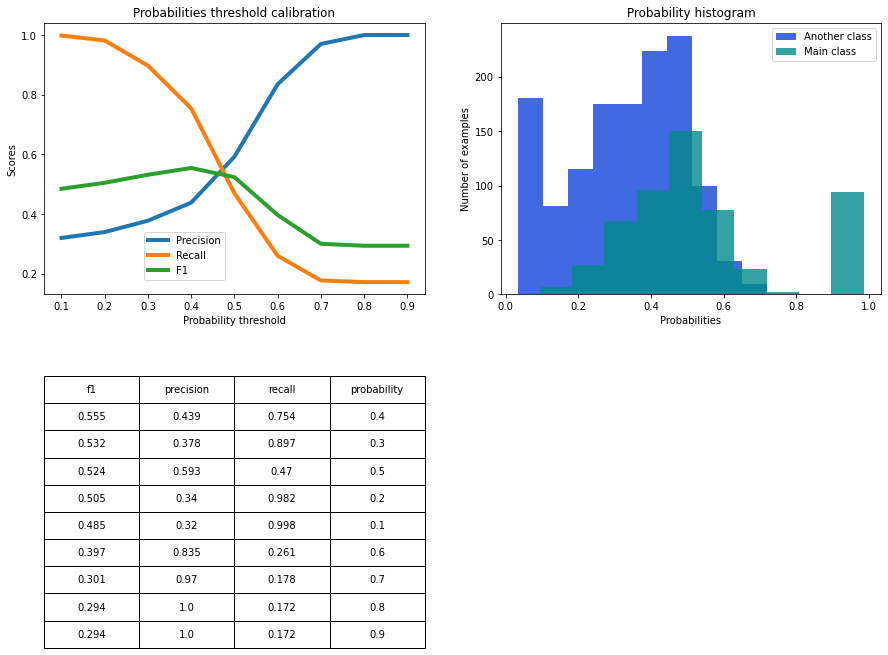

In [387]:
show_proba_calibration_plots(y_valid_pred_probs[:, 1], y_valid)

Посмотрим значимость признаков в работе данной модели

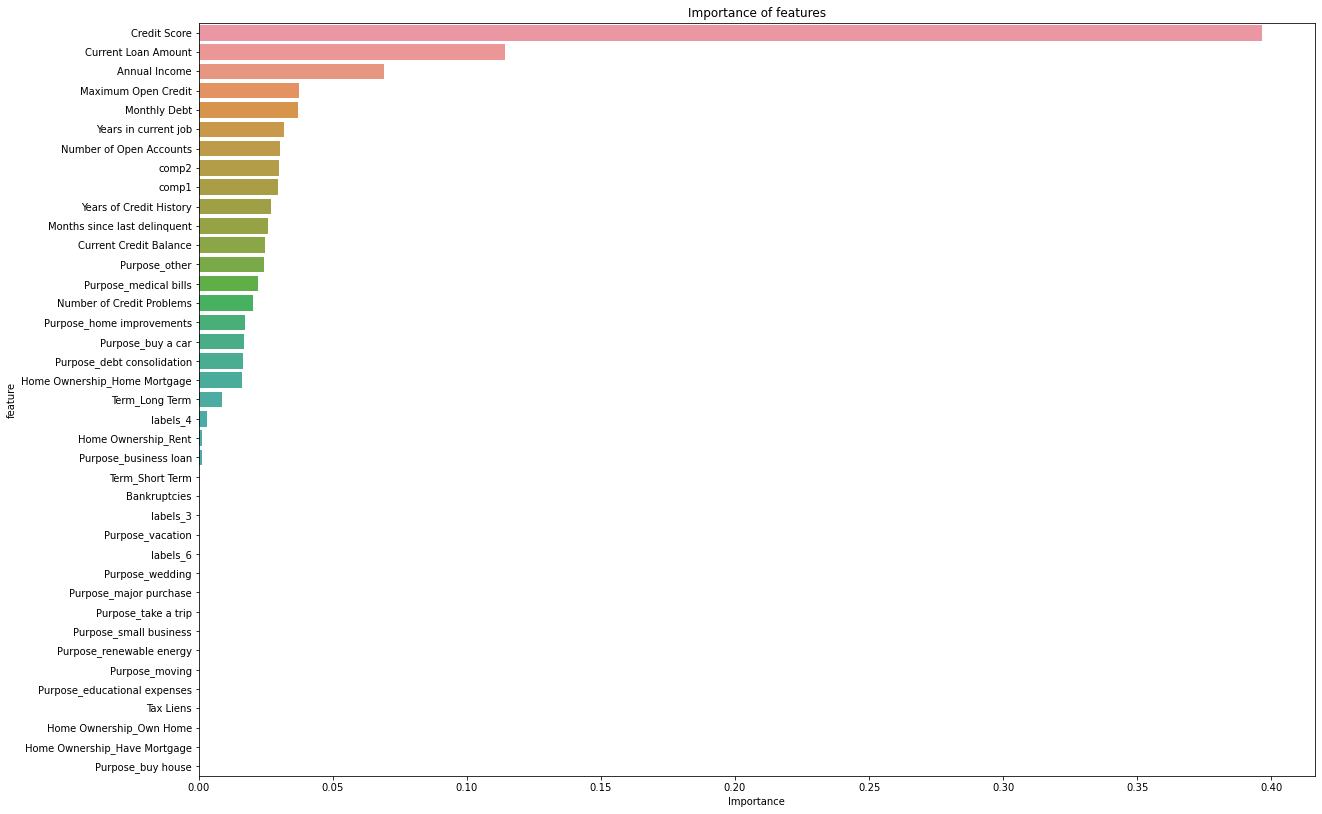

In [388]:
important_features_top = show_feature_importances(x_train_balanced_scaled_NO_CAT.columns, XGBclf.feature_importances_, get_top=15)

Исходя из анализа графиков установим порог вероятности для отнесения к 1 классу для xgb 0.4

In [389]:
#Порог для catboost 0.6

In [390]:
# y_valid_pred_probs_cat = cat_model.predict_proba(x_valid_CAT)
# y_valid_pred_cat = y_valid_pred_probs_cat[:,1]
# y_valid_pred_cat[y_valid_pred_cat>=0.6]=1
# y_valid_pred_cat[y_valid_pred_cat<0.6]=0
# y_valid_pred_cat

In [391]:
#cat
# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred_cat)

In [392]:
y_train_pred_probs_xgb = XGBclf.predict_proba(x_train_balanced_scaled_NO_CAT)
y_train_pred_xgb = y_train_pred_probs_xgb[:,1]
y_train_pred_xgb[y_train_pred_xgb>=0.4]=1
y_train_pred_xgb[y_train_pred_xgb<0.4]=0
y_train_pred_xgb

array([1., 1., 0., ..., 0., 0., 0.], dtype=float32)

In [393]:
y_valid_pred_probs_xgb = XGBclf.predict_proba(x_valid_NO_CAT)
y_valid_pred_xgb = y_valid_pred_probs_xgb[:,1]
y_valid_pred_xgb[y_valid_pred_xgb>=0.4]=1
y_valid_pred_xgb[y_valid_pred_xgb<0.4]=0
y_valid_pred_xgb

array([1., 1., 0., ..., 1., 0., 0.], dtype=float32)

In [394]:
#xgb
get_classification_report(y_train_balanced, y_train_pred_xgb, y_valid, y_valid_pred_xgb)

TRAIN

              precision    recall  f1-score   support

           0       0.84      0.63      0.72      4054
           1       0.64      0.85      0.73      3136

    accuracy                           0.73      7190
   macro avg       0.74      0.74      0.72      7190
weighted avg       0.75      0.73      0.72      7190

TEST

              precision    recall  f1-score   support

           0       0.86      0.60      0.71      1330
           1       0.44      0.75      0.55       545

    accuracy                           0.65      1875
   macro avg       0.65      0.68      0.63      1875
weighted avg       0.74      0.65      0.66      1875

CONFUSION MATRIX

col_0           0.0  1.0
Credit Default          
0               804  526
1               134  411


In [395]:
#params = {'n_estimators':[100,1000,1500,5000],
#     'learning_rate': [0.01,0.1,0.5],
#     'min_child_samples': [5,17,49],
#     'max_depth': [5,10,50]
# }

In [396]:
# cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [397]:
# %%time

# rs = RandomizedSearchCV(lgbm_model, params, scoring='f1', cv=cv, n_jobs=-1)
# rs.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

In [398]:
# rs.best_params_

In [399]:
# rs.best_score_

In [400]:
# lgbm_model = lgbm.LGBMClassifier(random_state=21, n_estimators=500,
# min_child_samples=5,
# max_depth=3,
# learning_rate=0.1, class_weights=[1, 3.5])

# lgbm_model.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

# y_train_pred = lgbm_model.predict(x_train_balanced_scaled_NO_CAT)
# y_valid_pred = lgbm_model.predict(x_valid_NO_CAT)
# y_valid_pred_probs = lgbm_model.predict_proba(x_valid_NO_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

In [401]:
#parameters = [{'n_estimators': [10, 15, 50, 100, 200, 400], 'max_features': np.arange(3, 10), 'max_depth': np.arange(4, 10)}]

In [402]:
#clf = GridSearchCV(estimator=RandomForestClassifier(random_state=100), param_grid=parameters, scoring= 'f1', cv=3)

In [403]:
#clf.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

In [404]:
#clf.best_params_

In [405]:
#clf.best_score_

In [406]:
# RFclf = RandomForestClassifier(random_state=21, max_depth=9, max_features=9, n_estimators=10)

# RFclf.fit(x_train_balanced_scaled_NO_CAT, y_train_balanced)

# y_train_pred = RFclf.predict(x_train_balanced_scaled_NO_CAT)
# y_valid_pred = RFclf.predict(x_valid_NO_CAT)
# y_valid_pred_probs = RFclf.predict_proba(x_valid_NO_CAT)

# get_classification_report(y_train_balanced, y_train_pred, y_valid, y_valid_pred)

Обработаем тестовые данные и сделаем предсказания исходя из порога вероятностей 0.4

In [407]:
df_test.head()

Home Ownership  Annual Income Years in current job  Tax Liens  \
0           Rent            NaN              4 years        0.0   
1           Rent       231838.0               1 year        0.0   
2  Home Mortgage      1152540.0              3 years        0.0   
3  Home Mortgage      1220313.0            10+ years        0.0   
4  Home Mortgage      2340952.0              6 years        0.0   

   Number of Open Accounts  Years of Credit History  Maximum Open Credit  \
0                      9.0                     12.5             220968.0   
1                      6.0                     32.7              55946.0   
2                     10.0                     13.7             204600.0   
3                     16.0                     17.0             456302.0   
4                     11.0                     23.6            1207272.0   

   Number of Credit Problems  Months since last delinquent  Bankruptcies  \
0                        0.0                          70.0           0.0   
1                        0.0                           8.0           0.0   
2                        0.0                           NaN           0.0   
3                        0.0                          70.0           0.0   
4                        0.0                           NaN           0.0   

                Purpose        Term  Current Loan Amount  \
0    debt consolidation  Short Term             162470.0   
1  educational expenses  Short Term              78298.0   
2    debt consolidation  Short Term             200178.0   
3    debt consolidation  Short Term             217382.0   
4    debt consolidation   Long Term             777634.0   

   Current Credit Balance  Monthly Debt  Credit Score  
0                105906.0        6813.0           NaN  
1                 46037.0        2318.0         699.0  
2                146490.0       18729.0        7260.0  
3                213199.0       27559.0         739.0  
4                425391.0       42605.0         706.0

In [408]:
for colname in CAT_FEATURE_NAMES:
    df_test[colname] = pd.Categorical(df_test[colname])
    
df_test[CAT_FEATURE_NAMES].dtypes

Home Ownership    category
Purpose           category
Term              category
dtype: object

In [409]:
x_test_CAT, x_test_NO_CAT = test_transform(df_test)

In [410]:
x_test_CAT.head()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
0      -0.182782             -0.545214   -0.11912                -0.445658   
1      -1.474790             -1.413516   -0.11912                -1.056345   
2      -0.204822             -0.834648   -0.11912                -0.242095   
3      -0.111340              1.191388   -0.11912                 0.979280   
4       1.434410              0.033653   -0.11912                -0.038533   

   Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                -0.820581            -0.359184                  -0.338951   
1                 2.035687            -0.492046                  -0.338951   
2                -0.650901            -0.372362                  -0.338951   
3                -0.184283            -0.169712                  -0.338951   
4                 0.748953             0.434909                  -0.338951   

   Months since last delinquent  Bankruptcies  Current Loan Amount  ...  \
0                      2.382214     -0.338603            -0.861928  ...   
1                     -0.350978     -0.338603            -1.346617  ...   
2                     -0.703648     -0.338603            -0.644794  ...   
3                      2.382214     -0.338603            -0.545728  ...   
4                     -0.703648     -0.338603             2.680376  ...   

   Monthly Debt  Credit Score  Home Ownership               Purpose  \
0     -0.973673     -0.299146            Rent    debt consolidation   
1     -1.355058     -0.317617            Rent  educational expenses   
2      0.037358      3.354779   Home Mortgage    debt consolidation   
3      0.786552     -0.295227   Home Mortgage    debt consolidation   
4      2.063152     -0.313699   Home Mortgage    debt consolidation   

         Term labels_3  labels_4  labels_6     comp1     comp2  
0  Short Term        1         0         0 -1.824785 -1.662106  
1  Short Term        1         0         0 -1.907930 -2.253754  
2  Short Term        1         0         2 -0.642787 -0.891649  
3  Short Term        1         0         3  0.825958  0.335871  
4   Long Term        2         1         1 -0.691230  3.221820  

[5 rows x 21 columns]

In [411]:
x_test_NO_CAT.head()

Annual Income  Years in current job  Tax Liens  Number of Open Accounts  \
0      -0.182782             -0.545214   -0.11912                -0.445658   
1      -1.474790             -1.413516   -0.11912                -1.056345   
2      -0.204822             -0.834648   -0.11912                -0.242095   
3      -0.111340              1.191388   -0.11912                 0.979280   
4       1.434410              0.033653   -0.11912                -0.038533   

   Years of Credit History  Maximum Open Credit  Number of Credit Problems  \
0                -0.820581            -0.359184                  -0.338951   
1                 2.035687            -0.492046                  -0.338951   
2                -0.650901            -0.372362                  -0.338951   
3                -0.184283            -0.169712                  -0.338951   
4                 0.748953             0.434909                  -0.338951   

   Months since last delinquent  Bankruptcies  Current Loan Amount  ...  \
0                      2.382214     -0.338603            -0.861928  ...   
1                     -0.350978     -0.338603            -1.346617  ...   
2                     -0.703648     -0.338603            -0.644794  ...   
3                      2.382214     -0.338603            -0.545728  ...   
4                     -0.703648     -0.338603             2.680376  ...   

   Purpose_vacation  Purpose_wedding  Term_Long Term  Term_Short Term  \
0                 0                0               0                1   
1                 0                0               0                1   
2                 0                0               0                1   
3                 0                0               0                1   
4                 0                0               1                0   

   Purpose_renewable energy  labels_3  labels_4  labels_6     comp1     comp2  
0                         0         1         0         0 -1.824785 -1.662106  
1                         0         1         0         0 -1.907930 -2.253754  
2                         0         1         0         2 -0.642787 -0.891649  
3                         0         1         0         3  0.825958  0.335871  
4                         0         2         1         1 -0.691230  3.221820  

[5 rows x 39 columns]

In [412]:
x_test_NO_CAT.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score',
       'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Purpose_major purchase',
       'Purpose_medical bills', 'Purpose_moving', 'Purpose_other',
       'Purpose_small business', 'Purpose_take a trip', 'Purpose_vacation',
       'Purpose_wedding', 'Term_Long Term', 'Term_Short Term',
       'Purpose_renewable energy', 'labels_3', 'labels_4', 'labels_6', 'comp1',
       'comp2'],
      dtype='object')

In [413]:
x_train_balanced_scaled_NO_CAT.columns

Index(['Annual Income', 'Years in current job', 'Tax Liens',
       'Number of Open Accounts', 'Years of Credit History',
       'Maximum Open Credit', 'Number of Credit Problems',
       'Months since last delinquent', 'Bankruptcies', 'Current Loan Amount',
       'Current Credit Balance', 'Monthly Debt', 'Credit Score',
       'Home Ownership_Have Mortgage', 'Home Ownership_Home Mortgage',
       'Home Ownership_Own Home', 'Home Ownership_Rent',
       'Purpose_business loan', 'Purpose_buy a car', 'Purpose_buy house',
       'Purpose_debt consolidation', 'Purpose_educational expenses',
       'Purpose_home improvements', 'Purpose_major purchase',
       'Purpose_medical bills', 'Purpose_moving', 'Purpose_other',
       'Purpose_renewable energy', 'Purpose_small business',
       'Purpose_take a trip', 'Purpose_vacation', 'Purpose_wedding',
       'Term_Long Term', 'Term_Short Term', 'labels_3', 'labels_4', 'labels_6',
       'comp1', 'comp2'],
      dtype='object')

In [414]:
x_test_NO_CAT = x_test_NO_CAT[x_train_balanced_scaled_NO_CAT.columns]

In [415]:
y_test_pred_probs_xgb = XGBclf.predict_proba(x_test_NO_CAT)
y_test_pred_xgb = y_test_pred_probs_xgb[:,1]
y_test_pred_xgb[y_test_pred_xgb>=0.4]=1
y_test_pred_xgb[y_test_pred_xgb<0.4]=0
y_test_pred_xgb

array([1., 1., 1., ..., 1., 0., 1.], dtype=float32)

In [416]:
predictions = pd.DataFrame(y_test_pred_xgb, columns = ['Credit Default'])

In [417]:
predictions['Credit Default'].shape[0]

2500

In [418]:
predictions['Id'] = np.arange(predictions['Credit Default'].shape[0])

In [419]:
predictions = predictions[['Id', 'Credit Default']]

In [420]:
predictions['Credit Default']=predictions['Credit Default'].astype('int')

In [421]:
predictions

Id  Credit Default
0        0               1
1        1               1
2        2               1
3        3               1
4        4               0
...    ...             ...
2495  2495               0
2496  2496               1
2497  2497               1
2498  2498               0
2499  2499               1

[2500 rows x 2 columns]

In [422]:
predictions.to_csv('predictions_Lapina_E_O.csv', index=False)

In [423]:
# y_test_pred_probs_cat = cat_model.predict_proba(x_test_CAT)
# y_test_pred_cat = y_test_pred_probs_cat[:,1]
# y_test_pred_cat[y_test_pred_cat>=0.6]=1
# y_test_pred_cat[y_test_pred_cat<0.6]=0
# y_test_pred_cat

In [356]:
# predictions_cat = pd.DataFrame(y_test_pred_cat, columns = ['Credit Default'])

In [357]:
# predictions_cat['Id'] = np.arange(predictions_cat['Credit Default'].shape[0])

In [358]:
# predictions_cat= predictions_cat[['Id', 'Credit Default']]

In [359]:
# predictions_cat['Credit Default']=predictions_cat['Credit Default'].astype('int')

In [360]:
# predictions_cat

In [361]:
# predictions_cat.to_csv('predictions_cat_Lapina_E_O.csv', index=False)